In [1]:
import xmltodict
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Проработаем все датасеты. Почистим от ненужных переменных.

## Датасет по поставщикам из РНП

In [3]:
# открываю таблицу с указанием типов данных
dtype_dict = {'publish_date': 'string',
              'reason': 'string',
              'customer_code': 'string',
              'customer_inn': 'string',
              'customer_kpp': 'string',
              'supplier_full_name': 'string',
              'supplier_type': 'string',
              'supplier_inn': 'string',
              'supplier_kpp': 'string',
              'purchase_object': 'string',
              'contract_object': 'string',
              'contract_price_currency': 'string',
              'purchase_object': 'string'
             }  # словарь с типами данных для нужных столбцов
df1 = pd.read_csv('dataframe_final.csv', encoding='utf-8', dtype=dtype_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'dataframe_final.csv'

### Почему за 2022 мало наблюдений

In [26]:
# поймем причину малого количества записей за 2022 год

# Фильтруем строки, где год публикации равен 2022
df_filtered = df1[df1['publish_date_year'] == 2022]

# Преобразуем строки столбца 'publish_date' в datetime
# Параметр errors='coerce' преобразует неподходящие строки в NaT (Not a Time), их можно будет исключить, если таковые найдутся
df_filtered['publish_date'] = pd.to_datetime(df_filtered['publish_date'], errors='coerce')

# Проверяем, есть ли NaT значения, которые могли возникнуть при ошибочных данных
if df_filtered['publish_date'].isnull().any():
    print("Некоторые даты не удалось преобразовать.")

# Находим максимальную дату
max_date = df_filtered['publish_date'].max()

print("Максимальная дата публикации в 2022 году:", max_date)

Некоторые даты не удалось преобразовать.
Максимальная дата публикации в 2022 году: 2022-03-31 00:00:00


C:\Users\ww\AppData\Local\Temp\ipykernel_13332\4193719174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['publish_date'] = pd.to_datetime(df_filtered['publish_date'], errors='coerce')


### Резиденты / Нерезиденты

In [34]:
df1['supplier_type'].value_counts()

supplier_type
U     48280
P     11708
UF     1826
PF      761
Name: count, dtype: Int64

In [33]:
df1[df1['supplier_type'] == 'UF']['supplier_inn'].str.len().value_counts().sort_index()

supplier_inn
10    1797
12      29
Name: count, dtype: Int64

Тестово подтянем данные из СПАРК, посмотрим, мэтчатся ли компании  UF и PF

In [37]:
comp_main_spark_info = pd.read_csv('comp_main_spark_info.csv')

# Приведение типов данных столбцов к строкам
df1['supplier_inn'] = df1['supplier_inn'].astype(str)
comp_main_spark_info['inn'] = comp_main_spark_info['inn'].astype(str)

# Left join операция
result = df1.merge(comp_main_spark_info[['inn']], left_on='supplier_inn', right_on='inn', how='left', indicator=True)

# Добавление столбца 'check'
result['check'] = result['_merge'] == 'both'

# Удаление ненужных столбцов
result.drop(columns=['inn', '_merge'], inplace=True)

result

,publish_date_year,publish_date,reason,customer_code,customer_inn,customer_kpp,supplier_full_name,supplier_type,supplier_inn,supplier_kpp,founders_inn_role,purchase_object,contract_object,contract_price_currency,contract_price_amount,final_object,check
0,2014,2014-01-21 14:22:11.636,CANCEL_CONTRACT,3243000884,2901056972,290101001,"ООО ""Строительные технологии""",U,2901235160,<NA>,[],На право заключения гражданско-правового догов...,ремонту крылец педиатрического корпуса по адре...,RUB,990688.90,ремонту крылец педиатрического корпуса по адре...,True
1,2014,2014-01-24 15:47:55.179,CANCEL_CONTRACT,1572000045,6027087514,602701001,"ООО ""РОСПРОМТОРГ""",U,6321299175,<NA>,[],Размещение заказа на право заключить государс...,выполнение работ по установке недостающих доро...,RUB,13499999.99,выполнение работ по установке недостающих доро...,True
2,2014,2014-01-24 17:00:36.339,CANCEL_CONTRACT,3172000228,2225022328,222501001,"Общество с ограниченной ответственностью ""Гермес""",U,2225097612,222501001,[],Поставка продуктов питания (картофель) для нуж...,Поставка продуктов питания (картофель) для нуж...,RUB,248958.56,Поставка продуктов питания (картофель) для нуж...,True
3,2014,2014-01-27 11:59:04.391,CANCEL_CONTRACT,1731000147,7701903677,770101001,"ООО ""АктивСтройСервис""",U,7728800929,<NA>,[],Выполнение ремонта скатной кровли администрати...,Выполнение работ по ремонту скатной кровли адм...,RUB,2420682.53,Выполнение работ по ремонту скатной кровли адм...,True
4,2014,2014-01-27 12:17:33.049,CANCEL_CONTRACT,6351000001,3908005986,390601001,"Общество с ограниченной ответственностью ""ПЕГАС""",U,7713754973,771301001,[],Поставка бланков «Мореходная книжка» в количес...,"Поставка бланков ""Мореходная книжка"" для нужд ...",RUB,542741.85,"Поставка бланков ""Мореходная книжка"" для нужд ...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62579,2018,2018-03-01,CANCEL_CONTRACT,1373000229,4003005597,400301001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОПТО...",U,4025419633,402501001,"[['402571207928', None]]",Выполнение работ по ремонту фасада МФЦ на ул. ...,Выполнение работ по ремонту фасада МФЦ на ул. ...,RUB,416000.00,Выполнение работ по ремонту фасада МФЦ на ул. ...,True
62580,2018,2018-03-01,CANCEL_CONTRACT,1463000090,4826021756,482601001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ТРИУМФ""",U,1215214501,121501001,"[['121526353197', None]]",услуги по переносу на базу системы управления ...,услуги по переносу на базу системы управления...,RUB,31250.00,услуги по переносу на базу системы управления...,True
62581,2018,2018-02-19,WINNER_DEVIATION,8104000013,1510018007,151001001,"ООО ""Т-2""",U,5022030921,502201001,"[['502200312533', None], ['502206194300', None]]",Консервы: маринады овощные,"Консервы: маринады овощные ""Лук репчатый марин...",RUB,4011464.28,"Консервы: маринады овощные ""Лук репчатый марин...",True
62582,2018,2018-02-19,WINNER_DEVIATION,3483005360,5043007144,504301001,ООО «Биосфера»,U,6234117365,623401001,[],"Оказание услуг по проведению дезинсекции, дера...","Услуги по дезинфекции, дезинсекции и дератизац...",RUB,583221.86,"Услуги по дезинфекции, дезинсекции и дератизац...",True


In [38]:
result['check'].value_counts()

check
True     47630
False    14954
Name: count, dtype: int64

In [39]:
entrepreneurs_spark_info = pd.read_csv('enterpreneurs_spark_info.csv')

entrepreneurs_spark_info['inn'] = entrepreneurs_spark_info['inn'].astype(str)

# Второе слияние
result = result.merge(entrepreneurs_spark_info[['inn']], left_on='supplier_inn', right_on='inn', how='left', indicator=True)
result['check_2'] = result['_merge'] == 'both'
result.drop(columns=['inn', '_merge'], inplace=True)

# Создание финального столбца 'check_final'
result['check_final'] = result['check'] | result['check_2']

In [42]:
result[result['check_final'] == False]['supplier_type'].value_counts()

supplier_type
U     1779
P     1049
UF      83
PF      55
Name: count, dtype: Int64

In [43]:
result['check_final'].value_counts()

check_final
True     59618
False     2966
Name: count, dtype: int64

в итоге не совсем понятно, что конкретно supplier_type отражает, так как большинство анмэтча со спарком - это U и P, которые как будто должны указавать на резидентов

### Причины добавления в РНП

In [45]:
df1['reason'].value_counts()

reason
CANCEL_CONTRACT                                 42216
WINNER_DEVIATION                                19949
ONE_WINNER_DEVIATION                              329
PARTICIPANT_DEVIATION_IF_WINNER_DEVIATION          40
Расторжение контракта                              28
Уклонение победителя от заключения контракта       13
Name: count, dtype: Int64

Преобразовать в норм вид для конечного датасета

In [46]:
# Замена значений в столбце 'reason'
df1['reason'] = df1['reason'].replace({
    'ONE_WINNER_DEVIATION': 'WINNER_DEVIATION',
    'PARTICIPANT_DEVIATION_IF_WINNER_DEVIATION': 'WINNER_DEVIATION',
    'Уклонение победителя от заключения контракта': 'WINNER_DEVIATION',
    'Расторжение контракта': 'CANCEL_CONTRACT'
})

In [47]:
df1['reason'].value_counts()

reason
CANCEL_CONTRACT     42244
WINNER_DEVIATION    20331
Name: count, dtype: Int64

### Нужные столбцы

In [65]:
df1['publish_date'] = df1['publish_date'].str.split(' ').str[0]

In [68]:
needed_cols = df1[['supplier_inn', 'publish_date_year', 'publish_date', 'reason', 'contract_price_amount']]
needed_cols.to_csv('rnp_suppliers.csv', index=False)

## Датасет по ИП - СПАРК

### Суммируем значения по законам

In [76]:
df2 = pd.read_csv('enterpreneurs_spark_info.csv', encoding='utf-8')

In [72]:
# Список столбцов, которые необходимо пропустить при агрегации
skip_columns = {'reg_date', 'inn', 'region_name', 'region_code', 'main_okved_code', 'main_okved_name'}

# Создаем новый DataFrame для результатов
result_df = df2[list(skip_columns)].copy()

# Получаем список уникальных годов и показателей
years = set()
indicators = set()

for column in df2.columns:
    if column in skip_columns:
        continue
    parts = column.split('_')
    if len(parts) < 3:
        continue
    year = parts[1]
    indicator = parts[2]
    years.add(year)
    indicators.add(indicator)

# Преобразуем set в list и сортируем
years = sorted(list(years))
indicators = sorted(list(indicators))

# Обходим каждый год и показатель, агрегируя данные
for year in years:
    for indicator in indicators:
        # Собираем все столбцы, которые соответствуют текущему году и показателю
        columns_to_sum = [col for col in df2.columns if f'_{year}_{indicator}' in col]
        # Суммируем данные по этим столбцам, игнорируя NaN значения
        result_df[f'{year}_{indicator}'] = df2[columns_to_sum].sum(axis=1, min_count=1)

In [74]:
result_df.to_csv('test_entp_info.csv', index=False)

### Смэтчим значения с рнп, чтобы определить нужный год

In [18]:
test_entp_info = pd.read_csv('test_entp_info.csv', encoding='utf-8')

Обнаружился косяк данных, надо сохранить inn в формате строки, а то 0 вначале теряется

In [21]:
# Преобразуем столбец 'inn' в строковый тип
test_entp_info['inn'] = test_entp_info['inn'].astype(str)
# Применяем функцию, которая добавляет '0' в начало строки, если её длина равна 11
test_entp_info['inn'] = test_entp_info['inn'].apply(lambda x: '0' + x if len(x) == 11 else x)
# Создаём новый DataFrame для сохранения результатов
new_entp_info = test_entp_info.copy()
# Сохраняем новый DataFrame в CSV файл, указывая, что inn - это строка
new_entp_info.to_csv('enterpreneurs_spark_info_laws_agg.csv', index=False)

In [22]:
rnp_suppliers = pd.read_csv('rnp_suppliers.csv', encoding='utf-8', dtype={'supplier_inn': str})

In [78]:
enterpreneurs_spark = pd.read_csv('enterpreneurs_spark_info_laws_agg.csv', encoding='utf-8', dtype={'inn': str})

In [24]:
result = pd.merge(rnp_suppliers, enterpreneurs_spark, left_on='supplier_inn', right_on='inn', how='left')

In [28]:
filtered_result = result[result['supplier_inn'].str.len() == 12]

In [30]:
filtered_result.to_csv('rnp_enterpreneurs_info.csv', index=False)

### Агрегируем инфу по законам

In [36]:
df = pd.read_csv('rnp_enterpreneurs_info.csv', encoding='utf-8', dtype={'supplier_inn': str})

# Добавление столбцов signed_number_before_rnp и sum_before_rnp
df['signed_number_before_rnp'] = 0
df['sum_before_rnp'] = 0

# Итерация по каждой строке DataFrame
for index, row in df.iterrows():
    publish_year = row['publish_date_year']
    signed_number_before_rnp = 0
    sum_before_rnp = 0
    
    # Итерация по столбцам DataFrame
    for column in df.columns:
        if column.endswith('_SignedNumber'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                signed_number_before_rnp += row[column]
        elif column.endswith('_Sum'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                sum_before_rnp += row[column]
    
    # Запись значений в новые столбцы
    df.at[index, 'signed_number_before_rnp'] = signed_number_before_rnp
    df.at[index, 'sum_before_rnp'] = sum_before_rnp

In [37]:
df.to_csv('rnp_enterpreneurs_info_laws.csv', index=False)

In [41]:
# Выбираем нужные столбцы и переименовываем их
new_df = df[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'publish_date_year', 'publish_date', 'reason', 'contract_price_amount',
             'signed_number_before_rnp', 'sum_before_rnp']].copy()

new_df.rename(columns={
    'publish_date_year': 'rnp_entry_date_year',
    'publish_date': 'rnp_entry_date',
    'reason': 'rnp_reason',
    'signed_number_before_rnp': 'history_signed_contract_before_rnp',
    'sum_before_rnp': 'history_sum_price_before_rnp'
}, inplace=True)

new_df

,supplier_inn,reg_date,region_code,region_name,main_okved_code,main_okved_name,rnp_entry_date_year,rnp_entry_date,rnp_reason,contract_price_amount,history_signed_contract_before_rnp,history_sum_price_before_rnp
0,790100305411,2007-07-12,99.0,Еврейская автономная область,95.29,Ремонт прочих предметов личного потребления и ...,2018,2018-03-02,CANCEL_CONTRACT,60000.00,1,60000
1,470315042539,2012-08-08,41.0,Ленинградская область,18.12,Прочие виды полиграфической деятельности,2018,2018-03-02,CANCEL_CONTRACT,95000.00,25,8760426
2,231710329702,2012-06-13,3.0,Краснодарский край,77.11,Аренда и лизинг легковых автомобилей и легких ...,2018,2018-03-01,WINNER_DEVIATION,2649830.00,161,60026536
3,665912504111,2016-02-10,65.0,Свердловская область,73.11,Деятельность рекламных агентств,2018,2018-03-02,WINNER_DEVIATION,508640.00,29,121304151
4,260905656233,2016-05-25,7.0,Ставропольский край,33.12,Ремонт машин и оборудования,2018,2018-03-01,CANCEL_CONTRACT,10722.50,15,823499
...,...,...,...,...,...,...,...,...,...,...,...,...
13192,591107948760,2015-12-01,57.0,Пермский край,46.46,Торговля оптовая фармацевтической продукцией,2018,2018-02-08,WINNER_DEVIATION,284166.00,8,8713652
13193,595000381910,2015-09-15,57.0,Пермский край,45.20,Техническое обслуживание и ремонт автотранспор...,2018,2018-02-08,CANCEL_CONTRACT,346913.74,30,14978033
13194,741806019878,2016-02-02,75.0,Челябинская область,46.42,Торговля оптовая одеждой и обувью,2018,2018-02-19,WINNER_DEVIATION,63645.93,8,561468
13195,662302491681,2016-04-06,65.0,Свердловская область,01.13.3,Выращивание столовых корнеплодных и клубнеплод...,2018,2018-02-19,WINNER_DEVIATION,576270.00,0,0


In [44]:
new_df.to_csv('rnp_enterpreneurs_info_final.csv', index=False)

### Найдем разницу в датах реги и вхождения

In [50]:
new_df['reg_date'] = pd.to_datetime(new_df['reg_date'])
new_df['rnp_entry_date'] = pd.to_datetime(new_df['rnp_entry_date'])

# Вычисление разницы в годах
new_df['date_diff_years'] = (new_df['rnp_entry_date'].dt.year - new_df['reg_date'].dt.year)

In [53]:
new_df['date_diff'] = round(new_df['date_diff_days'] / 365, 1)

In [52]:
# Подсчет количества записей, где rnp_entry_date < reg_date
count_records = (new_df['rnp_entry_date'] < new_df['reg_date']).sum()

print("Количество записей, где rnp_entry_date < reg_date:", count_records)

Количество записей, где rnp_entry_date < reg_date: 1115


In [58]:
new_df['date_diff'] = new_df['date_diff'].apply(lambda x: np.nan if x < 0 else x)

In [61]:
# Выбираем нужные столбцы и переименовываем их
new_new_df = new_df[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'rnp_entry_date_year', 'rnp_entry_date', 'date_diff', 'rnp_reason', 'contract_price_amount',
             'history_signed_contract_before_rnp', 'history_sum_price_before_rnp']].copy()

new_new_df.rename(columns={
    'date_diff': 'date_diff_between_reg_entry'
}, inplace=True)

In [63]:
new_new_df.to_csv('rnp_enterpreneurs_info_final.csv', index=False)

## Датасет по ЮЛ - СПАРК

### Все по аналогии с ИП

In [64]:
df = pd.read_csv('comp_main_spark_info.csv', encoding='utf-8', dtype={'inn': str})

# Список столбцов, которые необходимо пропустить при агрегации
skip_columns = {'reg_date', 'shortname','inn', 'kpp', 'region_name', 'region_code', 'main_okved_code', 'main_okved_name'}

# Создаем новый DataFrame для результатов
result_df = df[list(skip_columns)].copy()

# Получаем список уникальных годов и показателей
years = set()
indicators = set()

for column in df.columns:
    if column in skip_columns:
        continue
    parts = column.split('_')
    if len(parts) < 3:
        continue
    year = parts[1]
    indicator = parts[2]
    years.add(year)
    indicators.add(indicator)

# Преобразуем set в list и сортируем
years = sorted(list(years))
indicators = sorted(list(indicators))

# Обходим каждый год и показатель, агрегируя данные
for year in years:
    for indicator in indicators:
        # Собираем все столбцы, которые соответствуют текущему году и показателю
        columns_to_sum = [col for col in df.columns if f'_{year}_{indicator}' in col]
        # Суммируем данные по этим столбцам, игнорируя NaN значения
        result_df[f'{year}_{indicator}'] = df[columns_to_sum].sum(axis=1, min_count=1)

In [65]:
result_df.to_csv('test_comp_info.csv', index=False)

In [73]:
result_df['inn'].value_counts()

inn
8603213388    2
7722483470    2
5005067209    2
5047169562    2
7452035322    1
             ..
4823070018    1
4823061366    1
4823060500    1
4823057264    1
9909201656    1
Name: count, Length: 23695, dtype: int64

откуда то были дубликаты, нужно их убрать

In [82]:
result_df = result_df.drop_duplicates(subset='inn', keep='first')

In [85]:
result = pd.merge(rnp_suppliers, result_df, left_on='supplier_inn', right_on='inn', how='left')
result

,supplier_inn,publish_date_year,publish_date,reason,contract_price_amount,main_okved_name,shortname,reg_date,region_code,inn,...,2020_SignedNumber,2020_Sum,2021_SignedNumber,2021_Sum,2022_SignedNumber,2022_Sum,2023_SignedNumber,2023_Sum,2024_SignedNumber,2024_Sum
0,2901235160,2014,2014-01-21,CANCEL_CONTRACT,990688.90,"Производство электромонтажных, санитарно-техни...","ООО ""СТРОИТЕЛЬНЫЕ ТЕХНОЛОГИИ""",2013-02-26,11.0,2901235160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6321299175,2014,2014-01-24,CANCEL_CONTRACT,13499999.99,"Торговля автомобильными деталями, узлами и при...","ООО ""РОСПРОМТОРГ""",2012-10-09,3.0,6321299175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2225097612,2014,2014-01-24,CANCEL_CONTRACT,248958.56,Аренда и лизинг легковых автомобилей и легких ...,"ООО ""ГЕРМЕС""",2008-10-06,1.0,2225097612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7728800929,2014,2014-01-27,CANCEL_CONTRACT,2420682.53,Строительство жилых и нежилых зданий,"ООО ""АКТИВСТРОЙСЕРВИС""",2012-03-12,45.0,7728800929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7713754973,2014,2014-01-27,CANCEL_CONTRACT,542741.85,Деятельность издательская,"ООО ""ПЕГАС""",2012-09-27,45.0,7713754973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62570,4025419633,2018,2018-03-01,CANCEL_CONTRACT,416000.00,Консультирование по вопросам коммерческой деят...,"ООО ""ОПТОВЫЙ ДОМ""",2008-11-01,29.0,4025419633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62571,1215214501,2018,2018-03-01,CANCEL_CONTRACT,31250.00,"Деятельность по обработке данных, предоставлен...","ООО ""ТРИУМФ""",2016-11-23,36.0,1215214501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62572,5022030921,2018,2018-02-19,WINNER_DEVIATION,4011464.28,Торговля оптовая фруктами и овощами,"ООО ""Т-2""",2001-12-21,46.0,5022030921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62573,6234117365,2018,2018-02-19,WINNER_DEVIATION,583221.86,Деятельность организаций санитарно-эпидемиолог...,"ООО ""БИОСФЕРА""",2013-05-23,61.0,6234117365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
filtered_result = result[result['supplier_inn'].str.len() == 10]
filtered_result.to_csv('rnp_comp_info.csv', index=False)

In [89]:
df = pd.read_csv('rnp_comp_info.csv', encoding='utf-8', dtype={'supplier_inn': str})

# Добавление столбцов signed_number_before_rnp и sum_before_rnp
df['signed_number_before_rnp'] = 0
df['sum_before_rnp'] = 0

# Итерация по каждой строке DataFrame
for index, row in df.iterrows():
    publish_year = row['publish_date_year']
    signed_number_before_rnp = 0
    sum_before_rnp = 0
    
    # Итерация по столбцам DataFrame
    for column in df.columns:
        if column.endswith('_SignedNumber'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                signed_number_before_rnp += row[column]
        elif column.endswith('_Sum'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                sum_before_rnp += row[column]
    
    # Запись значений в новые столбцы
    df.at[index, 'signed_number_before_rnp'] = signed_number_before_rnp
    df.at[index, 'sum_before_rnp'] = sum_before_rnp

In [91]:
df.to_csv('test_agg_rnp_comp_info.csv', index=False)

In [92]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['publish_date'] = pd.to_datetime(df['publish_date'])

df['date_diff_days'] = (df['publish_date'] - df['reg_date']).dt.days

df['date_diff'] = round(df['date_diff_days'] / 365, 1)

df['date_diff'] = df['date_diff'].apply(lambda x: np.nan if x < 0 else x)

In [94]:
df.to_csv('test_agg_rnp_comp_info.csv', index=False)

In [95]:
# Выбираем нужные столбцы и переименовываем их
new_df = df[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'publish_date_year', 'publish_date', 'date_diff', 'reason', 'contract_price_amount',
             'signed_number_before_rnp', 'sum_before_rnp']].copy()

new_df.rename(columns={
    'date_diff': 'date_diff_between_reg_entry',
    'publish_date_year': 'rnp_entry_date_year',
    'publish_date': 'rnp_entry_date',
    'reason': 'rnp_reason',
    'signed_number_before_rnp': 'history_signed_contract_before_rnp', 
    'sum_before_rnp': 'history_sum_price_before_rnp' 
}, inplace=True)

In [97]:
new_df.to_csv('rnp_companies_info_final.csv', index=False)

In [98]:
new_df.dtypes

supplier_inn                                  object
reg_date                              datetime64[ns]
region_code                                  float64
region_name                                   object
main_okved_code                               object
main_okved_name                               object
rnp_entry_date_year                            int64
rnp_entry_date                        datetime64[ns]
date_diff_between_reg_entry                  float64
rnp_reason                                    object
contract_price_amount                        float64
history_signed_contract_before_rnp             int64
history_sum_price_before_rnp                   int64
dtype: object

### Очистим от пропусков и дубликатов Фин показатели

In [19]:
comp_fin_spark_info = pd.read_csv('comp_fin_spark_info.csv', encoding='utf-8', dtype={'INN': str, 'Year': str})

In [21]:
# Сначала фильтруем DataFrame, чтобы исключить строки, где значения в 'Year' или 'INN' являются NaN
filtered_comp_fin_spark_info = comp_fin_spark_info.dropna(subset=['Year', 'INN'])

# Удаляем дубликаты, сохраняя только первое вхождение каждого дубликата
unique_comp_fin_spark_info = filtered_comp_fin_spark_info.drop_duplicates(subset=['Year', 'INN'], keep='first')

In [23]:
unique_comp_fin_spark_info.to_csv('comp_fin_spark_info_wa_na_dublicates.csv', index=False)

### Объединим РНП компании и Фин показатели

In [24]:
rnp_companies_info_final = pd.read_csv('rnp_companies_info_final.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
comp_fin_spark_info = pd.read_csv('comp_fin_spark_info_wa_na_dublicates.csv', encoding='utf-8', dtype={'INN': str, 'Year': str})

In [25]:
result = pd.merge(rnp_companies_info_final, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'rnp_entry_date_year'], 
                  right_on=['INN', 'Year'])

In [27]:
result.to_csv('test1.csv', index=False)

In [50]:
result['INN'].isna().sum() # количество несовпадений для точного года

19718

In [38]:
result[result['INN'].notna()].to_csv('rnp_companies_fin_info_full_match.csv', index=False) # это датасет с заполненными INN

In [42]:
result[result['INN'].isna()].iloc[:, :13].to_csv('rnp_companies_fin_info_NaNs_1iteration.csv', index=False) # это датасет с незаполненными INN + очищены лишние столбцы, чтобы заново проделать left join

#### Проведем итерацию с взятием Год - 1

In [44]:
rnp_companies_for_1iteration = pd.read_csv('rnp_companies_fin_info_NaNs_1iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

In [45]:
rnp_companies_for_1iteration['entry_year_minus_1'] = (rnp_companies_for_1iteration['rnp_entry_date_year'].astype(int) - 1).astype(str)

In [47]:
result1 = pd.merge(rnp_companies_for_1iteration, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_1'], 
                  right_on=['INN', 'Year'])

In [49]:
result1['INN'].isna().sum() # количество несовпадений для года - 1 

11452

In [51]:
19718-11452

8266

In [52]:
# то есть мы добавили к изначальному датасету еще 8 266 смэтченных данных

In [54]:
result1 = result1.drop('entry_year_minus_1', axis=1)

In [57]:
result1[result1['INN'].notna()].to_csv('rnp_companies_fin_info_match_on_year_minus_1.csv', index=False) # это датасет с заполненными INN

In [58]:
result1[result1['INN'].isna()].iloc[:, :13].to_csv('rnp_companies_fin_info_NaNs_2iteration.csv', index=False) # это датасет с незаполненными INN + очищены лишние столбцы, чтобы заново проделать left join

#### Проведем итерацию с взятием Год - 2

In [70]:
rnp_companies_for_2iteration = pd.read_csv('rnp_companies_fin_info_NaNs_2iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_2iteration['entry_year_minus_2'] = (rnp_companies_for_2iteration['rnp_entry_date_year'].astype(int) - 2).astype(str)

result2 = pd.merge(rnp_companies_for_2iteration, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_2'], 
                  right_on=['INN', 'Year'])

In [71]:
result2['INN'].isna().sum() # количество несовпадений для года - 2

8886

In [72]:
11452-8886

2566

In [74]:
# то есть мы добавили к изначальному датасету еще 2 566 смэтченных данных

In [73]:
result2 = result2.drop('entry_year_minus_2', axis=1)

In [81]:
result2[result2['INN'].notna()].to_csv('rnp_companies_fin_info_match_on_year_minus_2.csv', index=False) # это датасет с заполненными INN
result2[result2['INN'].isna()].iloc[:, :13].to_csv('rnp_companies_fin_info_NaNs_3iteration.csv', index=False) # это датасет с незаполненными INN + очищены лишние столбцы, чтобы заново проделать left join

#### Проведем итерацию с взятием Год - 3

In [82]:
rnp_companies_for_3iteration = pd.read_csv('rnp_companies_fin_info_NaNs_3iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_3iteration['entry_year_minus_3'] = (rnp_companies_for_3iteration['rnp_entry_date_year'].astype(int) - 3).astype(str)

result3 = pd.merge(rnp_companies_for_3iteration, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_3'], 
                  right_on=['INN', 'Year'])

In [83]:
result3['INN'].isna().sum() # количество несовпадений для года - 3

8459

In [84]:
8886-8459

427

видим, что добавилось 427 значений, но уже их учитывать не будем, так как я подумал, что Год-3 брать некорректно ну и + там больше уже меньше эффекта по количество новых мэтчей

#### Объединим получившиеся датасеты (полный мэтч, год-1, год-2) + анмэтч в виде rnp_companies_fin_info_NaNs_3iteration

должно получиться исходное количество записей - 49 378 

In [89]:
df1 = pd.read_csv('rnp_companies_fin_info_full_match.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df2 = pd.read_csv('rnp_companies_fin_info_match_on_year_minus_1.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df3 = pd.read_csv('rnp_companies_fin_info_match_on_year_minus_2.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df4 = pd.read_csv('rnp_companies_fin_info_NaNs_3iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

# Объединение DataFrame'ов
result = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [91]:
result.to_csv('test.csv', index=False)

In [92]:
result['INN'].isna().sum()

8886

все совпало

#### Отберем подходящие переменные для анализа

In [109]:
df_filtered = result

# Подсчет заполненности для каждого столбца, кроме 'INN'
column_fill_rates = (df_filtered.loc[:, df_filtered.columns].notna().sum() / len(df_filtered)) * 100

# Отбор столбцов с заполненностью более 75%
columns_above_75 = column_fill_rates[column_fill_rates > 75].index.tolist()

print("Столбцы с заполненностью более 75%:", columns_above_75)

Столбцы с заполненностью более 75%: ['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name', 'rnp_entry_date_year', 'rnp_entry_date', 'date_diff_between_reg_entry', 'rnp_reason', 'contract_price_amount', 'history_signed_contract_before_rnp', 'history_sum_price_before_rnp', 'INN', 'Year', 'Денежные средства и денежные эквиваленты', 'Кредиторская задолженность', 'Выручка', 'Чистая прибыль (убыток)']


In [110]:
# Выбираем нужные столбцы
new_df = result[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'rnp_entry_date_year', 'rnp_entry_date', 'date_diff_between_reg_entry', 'rnp_reason', 'contract_price_amount',
             'history_signed_contract_before_rnp', 'history_sum_price_before_rnp',
             'Денежные средства и денежные эквиваленты', 'Кредиторская задолженность', 'Выручка', 'Чистая прибыль (убыток)']].copy()

In [112]:
new_df.to_csv('rnp_companies_fin_info_final.csv', index=False)

### Объединим РНП компании и Фин показатели и Кол-во сотрудников

In [116]:
comp_empl_spark_info = pd.read_csv('comp_empl_spark_info.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

In [118]:
duplicates = comp_empl_spark_info[comp_empl_spark_info.duplicated(subset=['inn', 'year'], keep=False)]
duplicates

,inn,year,employees
29929,5005067209,2023,8
29930,5005067209,2022,9
29931,5005067209,2021,8
29932,5005067209,2019,68
30312,5005067209,2023,8
30313,5005067209,2022,9
30314,5005067209,2021,8
30315,5005067209,2019,68
31381,5047169562,2023,2
31382,5047169562,2022,2


In [120]:
comp_empl_spark_info_unique = comp_empl_spark_info.drop_duplicates(subset=['inn', 'year'], keep='first')

In [123]:
comp_empl_spark_info_unique.to_csv('comp_empl_spark_info_wa_dublicates.csv', index=False)

In [124]:
rnp_companies_fin_info = pd.read_csv('rnp_companies_fin_info_final.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
comp_empl_spark_info_unique = pd.read_csv('comp_empl_spark_info_wa_dublicates.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

In [126]:
result = pd.merge(rnp_companies_fin_info, comp_empl_spark_info_unique, 
                  how='left', 
                  left_on=['supplier_inn', 'rnp_entry_date_year'], 
                  right_on=['inn', 'year'])

In [128]:
result.to_csv('test.csv', index=False)

In [129]:
result['employees'].isna().sum()

22814

22 814 незаполненных записей, почти 50%. Проведем ту же схему с Годом-1, как в финансах

#### Год-1

In [2]:
result = pd.read_csv('test.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

In [6]:
result[result['inn'].notna()].to_csv('rnp_companies_fin_empl_match_on_year.csv', index=False) # это датасет с заполненными inn

In [7]:
result[result['inn'].isna()].iloc[:, :17].to_csv('rnp_companies_fin_empl_NaNs_1iteration.csv', index=False) # это датасет с незаполненными inn + очищены лишние столбцы, чтобы заново проделать left join

In [8]:
rnp_companies_for_1iteration = pd.read_csv('rnp_companies_fin_empl_NaNs_1iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_1iteration['entry_year_minus_1'] = (rnp_companies_for_1iteration['rnp_entry_date_year'].astype(int) - 1).astype(str)

comp_empl_spark_info_unique = pd.read_csv('comp_empl_spark_info_wa_dublicates.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

result2 = pd.merge(rnp_companies_for_1iteration, comp_empl_spark_info_unique, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_1'], 
                  right_on=['inn', 'year'])

In [10]:
result2['employees'].isna().sum()

16812

In [11]:
22814-16812

6002

In [12]:
result2 = result2.drop('entry_year_minus_1', axis=1)

result2[result2['inn'].notna()].to_csv('rnp_companies_fin_empl_match_on_year_minus_1.csv', index=False) # это датасет с заполненными inn
result2[result2['inn'].isna()].iloc[:, :17].to_csv('rnp_companies_fin_empl_NaNs_2iteration.csv', index=False) # это датасет с незаполненными inn + очищены лишние столбцы, чтобы заново проделать left join

#### Год-2

In [13]:
rnp_companies_for_2iteration = pd.read_csv('rnp_companies_fin_empl_NaNs_2iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_2iteration['entry_year_minus_2'] = (rnp_companies_for_2iteration['rnp_entry_date_year'].astype(int) - 2).astype(str)

comp_empl_spark_info_unique = pd.read_csv('comp_empl_spark_info_wa_dublicates.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

result2 = pd.merge(rnp_companies_for_2iteration, comp_empl_spark_info_unique, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_2'], 
                  right_on=['inn', 'year'])

In [14]:
result2['employees'].isna().sum()

15606

In [15]:
16812-15606

1206

In [16]:
result2 = result2.drop('entry_year_minus_2', axis=1)

result2[result2['inn'].notna()].to_csv('rnp_companies_fin_empl_match_on_year_minus_2.csv', index=False) # это датасет с заполненными inn
result2[result2['inn'].isna()].iloc[:, :17].to_csv('rnp_companies_fin_empl_NaNs_3iteration.csv', index=False) # это датасет с незаполненными inn + очищены лишние столбцы, чтобы заново проделать left join

#### Объединение

In [17]:
df1 = pd.read_csv('rnp_companies_fin_empl_match_on_year.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df2 = pd.read_csv('rnp_companies_fin_empl_match_on_year_minus_1.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df3 = pd.read_csv('rnp_companies_fin_empl_match_on_year_minus_2.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df4 = pd.read_csv('rnp_companies_fin_empl_NaNs_3iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

# Объединение DataFrame'ов
result = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [19]:
result['employees'].isna().sum()

15606

In [20]:
# Выбираем нужные столбцы
new_df = result[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'rnp_entry_date_year', 'rnp_entry_date', 'date_diff_between_reg_entry', 'rnp_reason', 'contract_price_amount',
             'history_signed_contract_before_rnp', 'history_sum_price_before_rnp', 'employees',
             'Денежные средства и денежные эквиваленты', 'Кредиторская задолженность', 'Выручка', 'Чистая прибыль (убыток)']].copy()

In [22]:
new_df.to_csv('rnp_companies_fin_employees_info_final.csv', index=False)

# Анализ данных. Распределения + последний штрих по обработке (добавим верхнеуровневый ОКВЭД)

## ИП

### Нужно проработать ОКВЭД. Создадим датасет, по которому будем мэтчить нужный уровень глубины по ОКВЭД

In [4]:
df_entp = pd.read_csv('rnp_enterpreneurs_info_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str})

In [14]:
df_entp['main_okved_code'].value_counts()

main_okved_code
41.20       760
46.90       527
81.10       356
43.21       289
49.41       242
           ... 
15.2          1
29.31         1
62.03         1
46.49.44      1
47.76.2       1
Name: count, Length: 697, dtype: int64

In [49]:
new_column = df_entp['main_okved_code'].str[:2]
# Выбираем позицию, где должен быть вставлен новый столбец (после 5-го столбца, индексация с нуля)
position = 6

# Вставляем столбец
df_entp.insert(loc=position, column='main_okved_code_class', value=new_column)

In [26]:
check_okved = pd.read_csv(r'D:\Рабочий стол\data-20240301-structure-20180402 (4).txt', 
                          encoding='utf-8', 
                          sep=';',
                          header=None,
                          names=['ОКВЭД', 'Коды ОКВЭД', 'Наименование разделов'])

In [28]:
check_okved.to_csv('okved_structure.csv', index=False)

Смэтчим название, соответствующее выведенному классу ОКВЭД

In [52]:
result = pd.merge(df_entp, check_okved[['Коды ОКВЭД', 'Наименование разделов']], 
                  left_on='main_okved_code_class', right_on='Коды ОКВЭД', how='left').drop(columns='Коды ОКВЭД')

In [58]:
new_column = result['Наименование разделов']
# Выбираем позицию, где должен быть вставлен новый столбец (после 6-го столбца, индексация с нуля)
position = 7
# Вставляем столбец
result.insert(loc=position, column='main_okved_name_class', value=new_column)

In [60]:
result.drop('Наименование разделов', axis=1, inplace=True)

In [62]:
result.to_csv('rnp_enterpreneurs_info_final_final.csv', index=False)

### Проверим распределения. Анализ данных

In [2]:
df = pd.read_csv('rnp_enterpreneurs_info_final_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str,
                            'main_okved_code_class': str})

In [74]:
df

,supplier_inn,reg_date,region_code,region_name,main_okved_code,main_okved_name,main_okved_code_class,main_okved_name_class,rnp_entry_date_year,rnp_entry_date,date_diff_between_reg_entry,rnp_reason,contract_price_amount,history_signed_contract_before_rnp,history_sum_price_before_rnp
0,790100305411,2007-07-12,99.0,Еврейская автономная область,95.29,Ремонт прочих предметов личного потребления и ...,95,"Ремонт компьютеров, предметов личного потребле...",2018,2018-03-02,10.6,CANCEL_CONTRACT,60000.00,1,60000
1,470315042539,2012-08-08,41.0,Ленинградская область,18.12,Прочие виды полиграфической деятельности,18,Деятельность полиграфическая и копирование нос...,2018,2018-03-02,5.6,CANCEL_CONTRACT,95000.00,25,8760426
2,231710329702,2012-06-13,3.0,Краснодарский край,77.11,Аренда и лизинг легковых автомобилей и легких ...,77,Аренда и лизинг,2018,2018-03-01,5.7,WINNER_DEVIATION,2649830.00,161,60026536
3,665912504111,2016-02-10,65.0,Свердловская область,73.11,Деятельность рекламных агентств,73,Деятельность рекламная и исследование конъюнкт...,2018,2018-03-02,2.1,WINNER_DEVIATION,508640.00,29,121304151
4,260905656233,2016-05-25,7.0,Ставропольский край,33.12,Ремонт машин и оборудования,33,Ремонт и монтаж машин и оборудования,2018,2018-03-01,1.8,CANCEL_CONTRACT,10722.50,15,823499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13192,591107948760,2015-12-01,57.0,Пермский край,46.46,Торговля оптовая фармацевтической продукцией,46,"Торговля оптовая, кроме оптовой торговли автот...",2018,2018-02-08,2.2,WINNER_DEVIATION,284166.00,8,8713652
13193,595000381910,2015-09-15,57.0,Пермский край,45.20,Техническое обслуживание и ремонт автотранспор...,45,Торговля оптовая и розничная автотранспортными...,2018,2018-02-08,2.4,CANCEL_CONTRACT,346913.74,30,14978033
13194,741806019878,2016-02-02,75.0,Челябинская область,46.42,Торговля оптовая одеждой и обувью,46,"Торговля оптовая, кроме оптовой торговли автот...",2018,2018-02-19,2.0,WINNER_DEVIATION,63645.93,8,561468
13195,662302491681,2016-04-06,65.0,Свердловская область,01.13.3,Выращивание столовых корнеплодных и клубнеплод...,01,"Растениеводство и животноводство, охота и пред...",2018,2018-02-19,1.9,WINNER_DEVIATION,576270.00,0,0


#### Распределение по supplier_inn

<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\997557782.py:25: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по ИНН.png')


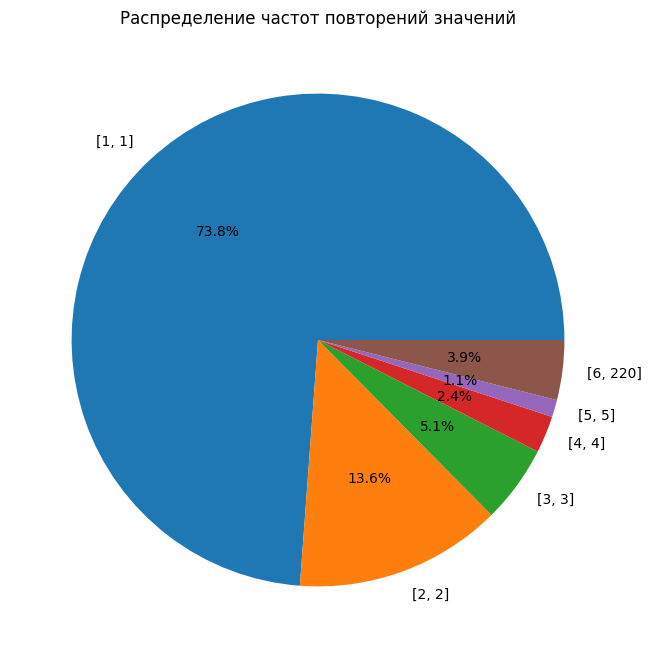

In [53]:
column = df['supplier_inn']

# Получаем количество каждого уникального значения в столбце
value_counts = column.value_counts()

# Получаем распределение частот повторений
frequency_distribution = value_counts.value_counts().sort_index()

# Общее количество элементов
total_counts = frequency_distribution.sum()

# Определяем, какие значения составляют менее 1% от общего числа
small_values = frequency_distribution[frequency_distribution / total_counts < 0.01]

# Объединяем малые значения в одну категорию
other_category_value = small_values.sum()
frequency_distribution = frequency_distribution[frequency_distribution / total_counts >= 0.01]
frequency_distribution['[{}, {}]'.format(small_values.index.min(), small_values.index.max())] = other_category_value

# Создаем круговую диаграмму
plt.figure(figsize=(12, 8))
frequency_distribution.plot(kind='pie', autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '', labels=['[{}, {}]'.format(i, i) if i not in ['[{}, {}]'.format(small_values.index.min(), small_values.index.max())] else i for i in frequency_distribution.index])
plt.title('Распределение частот повторений значений')
plt.ylabel('')  # Удаление метки оси y
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по ИНН.png') 
plt.show()

In [7]:
df['supplier_inn'].value_counts() == 1

supplier_inn
027503877932    False
231304110315    False
732895107688    False
366520895482    False
260601350910    False
                ...  
471508081487     True
402505478996     True
504303406353     True
572007791240     True
662302491681     True
Name: count, Length: 6912, dtype: bool

In [46]:
# Вычисляем количество вхождений каждого значения в столбце 'supplier_inn'
supplier_counts = df['supplier_inn'].value_counts()

# Находим INN, которые встречаются ровно 220 раз
inn_with_220_occurrences = supplier_counts[supplier_counts == 220].index

# Фильтруем основной DataFrame, чтобы отобразить только те строки, где 'supplier_inn' встречается 220 раз
filtered_df = df[df['supplier_inn'].isin(inn_with_220_occurrences)]

# Вычисляем среднее значение по столбцу 'contract_price_amount' для отфильтрованных строк
average_price = filtered_df['contract_price_amount'].mean()
print(f"Средняя цена контракта для INN с 220 вхождениями: {average_price}")


Средняя цена контракта для INN с 220 вхождениями: 34913.08477272726


#### Распределение по региону

In [ ]:
df['region_name'].value_counts()

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2860475084.py:11: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по регионам.png')  # Укажите нужный путь и формат файла


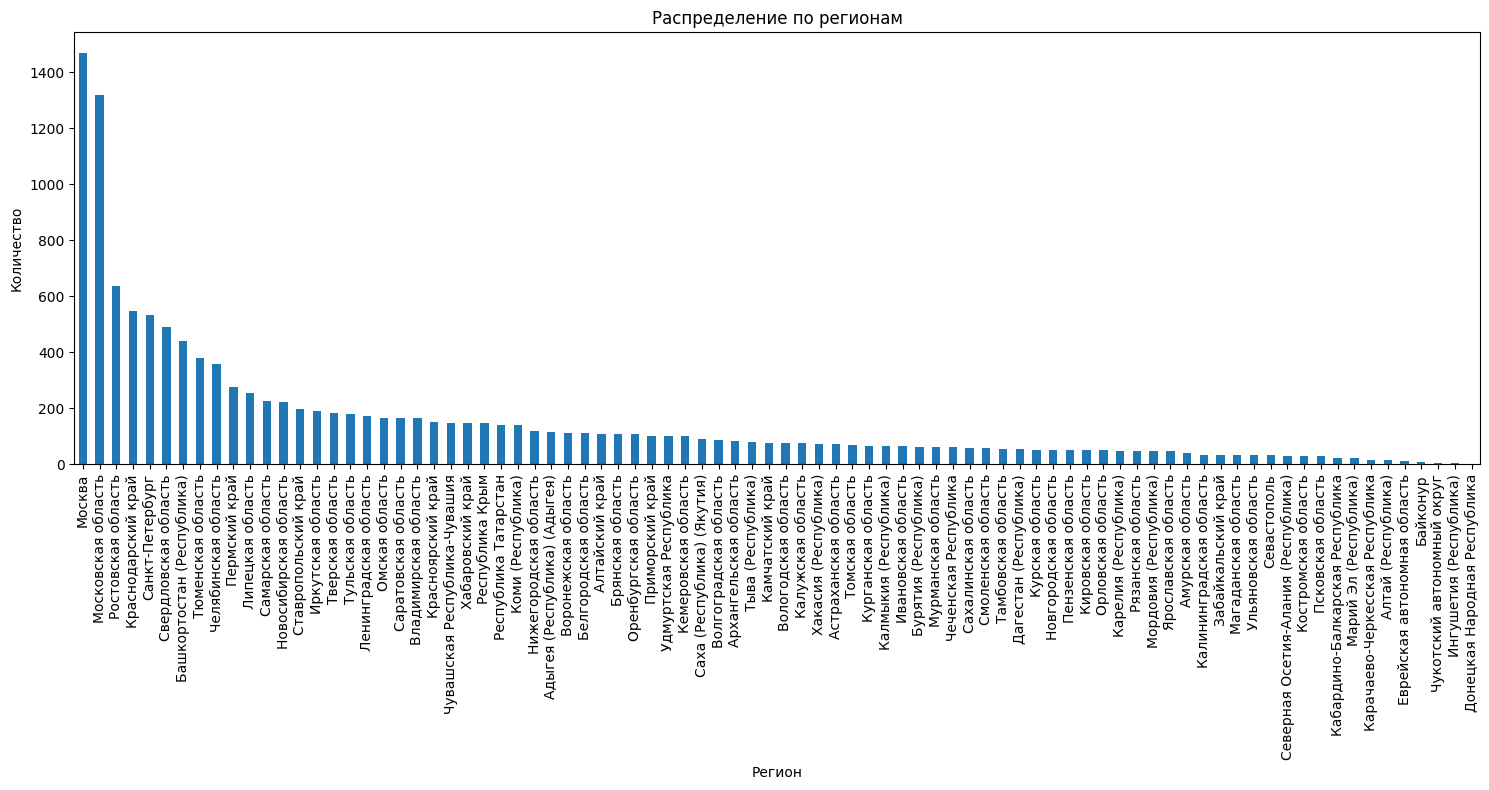

In [52]:
region_counts_sorted = df['region_name'].value_counts().sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(15, 8))
region_counts_sorted.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Распределение по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество')
plt.tight_layout()
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по регионам.png') 
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\1678235355.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ящик с усами по регионам.png')


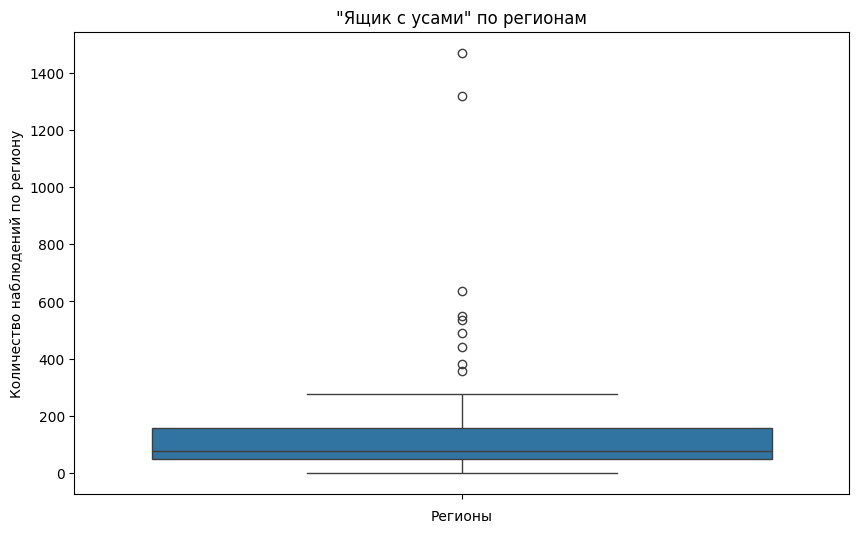

count      84.000000
mean      152.238095
std       233.573425
min         1.000000
25%        47.750000
50%        77.000000
75%       156.250000
max      1470.000000
Name: count, dtype: float64


In [80]:
# Подсчет количества для каждого региона
region_counts = df['region_name'].value_counts()

# Визуализация общего распределения
plt.figure(figsize=(10, 6))
sns.boxplot(data=region_counts)
plt.title('"Ящик с усами" по регионам')
plt.xlabel('Регионы')
plt.ylabel('Количество наблюдений по региону')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ящик с усами по регионам.png') 
plt.show()

# Вывод статистического анализа
print(region_counts.describe())

#### Распределение по виду деятельности

In [78]:
df['main_okved_name_class'].value_counts()

main_okved_name_class
Торговля оптовая, кроме оптовой торговли автотранспортными средствами и мотоциклами    2841
Торговля розничная, кроме торговли автотранспортными средствами и мотоциклами          1555
Работы строительные специализированные                                                 1219
Деятельность по обслуживанию зданий и территорий                                        970
Строительство зданий                                                                    820
                                                                                       ... 
Добыча прочих полезных ископаемых                                                         1
Деятельность водного транспорта                                                           1
Производство прочих транспортных средств и оборудования                                   1
Предоставление услуг в области добычи полезных ископаемых                                 1
Производство кокса и нефтепродуктов                       

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\1007768956.py:11: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по классам.png')


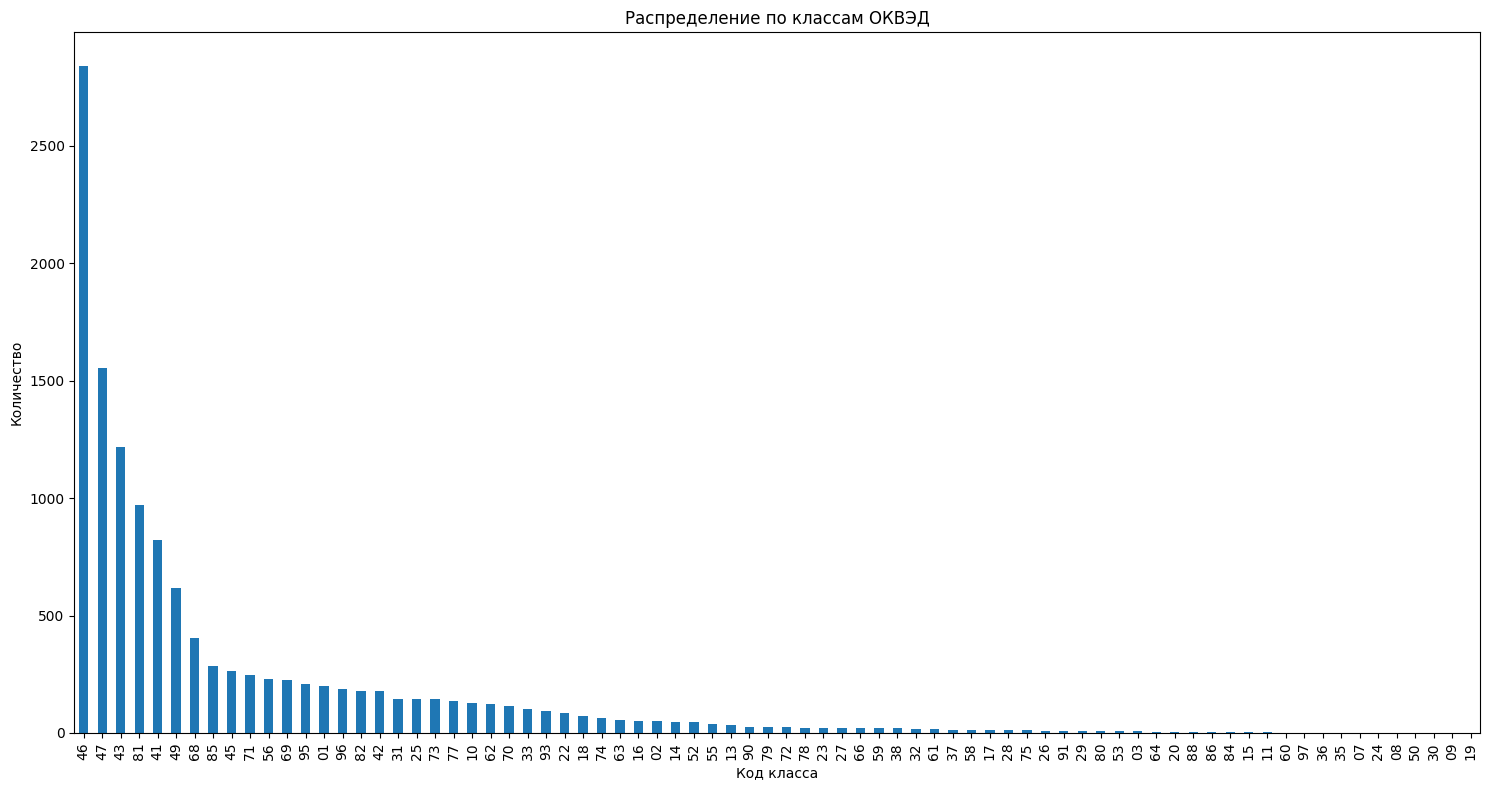

In [76]:
class_counts_sorted = df['main_okved_code_class'].value_counts().sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(15, 8))
class_counts_sorted.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Распределение по классам ОКВЭД')
plt.xlabel('Код класса')
plt.ylabel('Количество')
plt.tight_layout()
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по классам.png') 
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2787339548.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ящик с усами по классам.png')


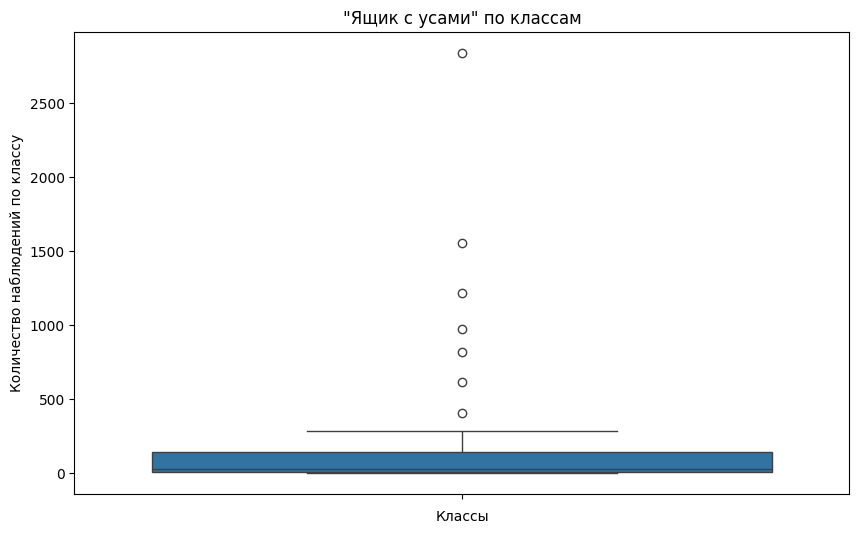

count      76.000000
mean      166.842105
std       411.364690
min         1.000000
25%         7.750000
50%        24.000000
75%       143.000000
max      2841.000000
Name: count, dtype: float64


In [81]:
# Подсчет количества для каждого класса
class_counts = df['main_okved_code_class'].value_counts()

# Визуализация общего распределения
plt.figure(figsize=(10, 6))
sns.boxplot(data=class_counts)
plt.title('"Ящик с усами" по классам')
plt.xlabel('Классы')
plt.ylabel('Количество наблюдений по классу')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ящик с усами по классам.png') 
plt.show()

# Вывод статистического анализа
print(class_counts.describe())

#### Распределение по годам добавления в РНП

In [83]:
df['rnp_entry_date_year'].value_counts()

rnp_entry_date_year
2021    3393
2020    2967
2019    2042
2018    1185
2022    1112
2015     801
2017     760
2016     597
2014     340
Name: count, dtype: int64

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2687292590.py:11: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по годам.png')


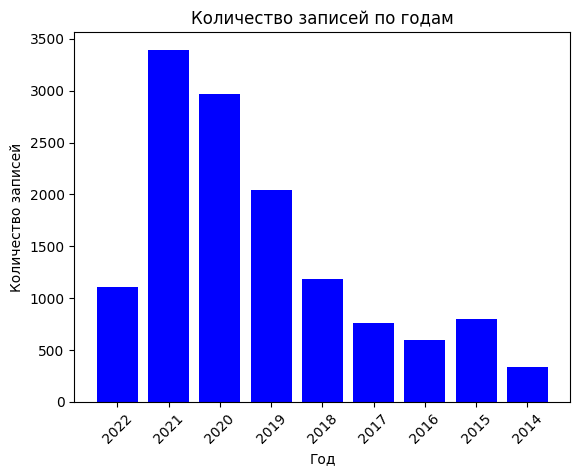

In [85]:
publish_count = df['rnp_entry_date_year'].value_counts().sort_index(ascending=False)

# Создаем гистограмму
plt.bar(publish_count.index.astype(str), publish_count.values, color='blue')

# Настройка визуализации
plt.xlabel('Год')
plt.ylabel('Количество записей')
plt.title('Количество записей по годам')
plt.xticks(rotation=45)  # Поворачиваем метки на оси X для лучшей читаемости
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по годам.png') 
# Показываем гистограмму
plt.show()

#### Распределение по разнице между годом регистрации и годом вхождения в РНП

In [86]:
df['date_diff_between_reg_entry']

0        10.6
1         5.6
2         5.7
3         2.1
4         1.8
         ... 
13192     2.2
13193     2.4
13194     2.0
13195     1.9
13196     1.1
Name: date_diff_between_reg_entry, Length: 13197, dtype: float64

In [89]:
df['date_diff_between_reg_entry'].describe()

count    11673.000000
mean         4.156626
std          4.112918
min          0.000000
25%          1.200000
50%          2.500000
75%          5.600000
max         18.100000
Name: date_diff_between_reg_entry, dtype: float64

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_16088\1261173093.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ИП\ящик с усами по reg_entry.png')


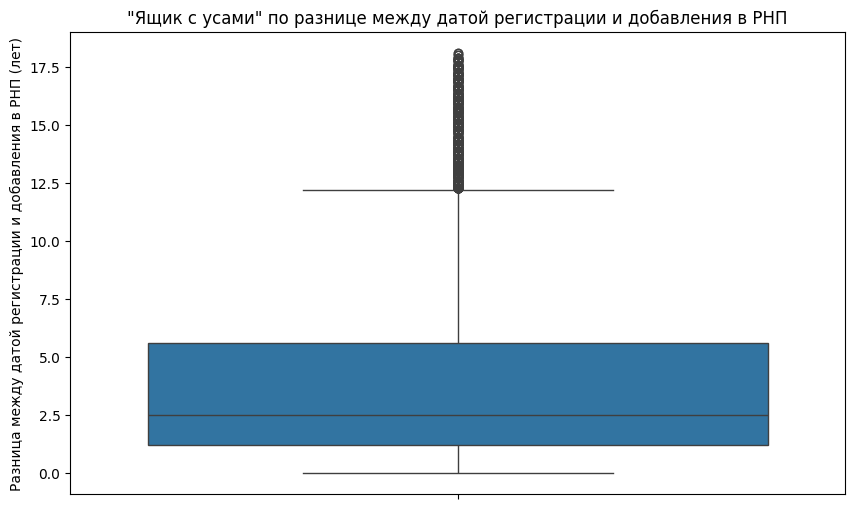

count    11673.000000
mean         4.156626
std          4.112918
min          0.000000
25%          1.200000
50%          2.500000
75%          5.600000
max         18.100000
Name: date_diff_between_reg_entry, dtype: float64


In [3]:
# Подсчет количества для каждого класса
date_counts = df['date_diff_between_reg_entry']

# Визуализация общего распределения
plt.figure(figsize=(10, 6))
sns.boxplot(data=date_counts)
plt.title('"Ящик с усами" по разнице между датой регистрации и добавления в РНП')
plt.xlabel('')
plt.ylabel('Разница между датой регистрации и добавления в РНП (лет)')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ИП\ящик с усами по reg_entry.png') 
plt.show()

# Вывод статистического анализа
print(date_counts.describe())

#### Распределение по причине добавления в РНП

In [91]:
df['rnp_reason'].value_counts()

rnp_reason
CANCEL_CONTRACT     7522
WINNER_DEVIATION    5675
Name: count, dtype: int64

#### Распределение по цене контракта

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_14396\505688703.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по ценам контракта.png')


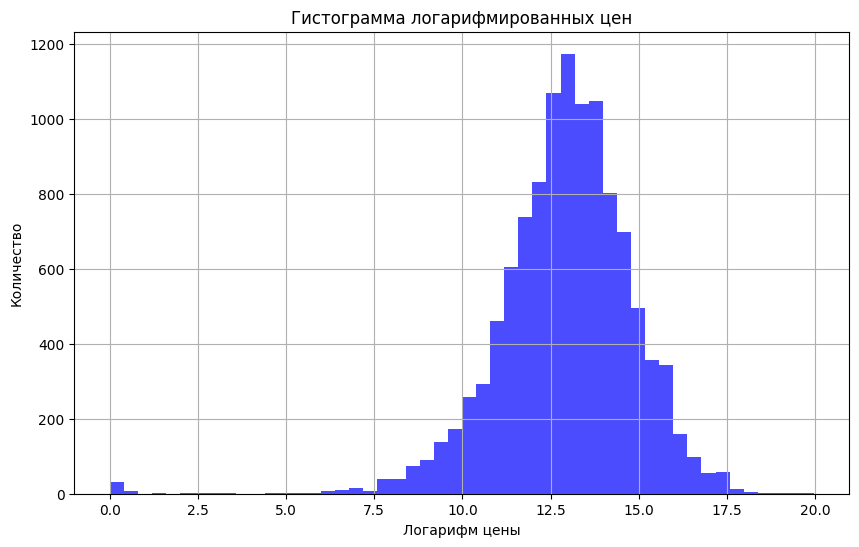

In [100]:
prices = df['contract_price_amount']

# Предположим, что prices - это ваш массив с ценами
prices = np.array(prices)  # Преобразование списка в массив NumPy, если это еще не сделано
log_prices = np.log(prices + 1)  # Логарифмирование цен, +1 чтобы избежать log(0)

plt.figure(figsize=(10, 6))
plt.hist(log_prices, bins=50, color='blue', alpha=0.7)
plt.title('Гистограмма логарифмированных цен')
plt.xlabel('Логарифм цены')
plt.ylabel('Количество')
plt.grid(True)
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по ценам контракта.png') 
plt.show()

In [93]:
prices = df['contract_price_amount']
print("Минимальная цена:", np.min(prices))
print("Максимальная цена:", np.max(prices))
print("Средняя цена:", np.mean(prices))
print("Медиана цен:", np.median(prices))
print("Стандартное отклонение:", np.std(prices))
print("Квартили:", np.percentile(prices, [25, 50, 75]))

print("Медиана цен (игнорируя NaN):", np.nanmedian(prices))
print("Квартили (игнорируя NaN):", np.nanpercentile(prices, [25, 50, 75]))

Минимальная цена: 0.0
Максимальная цена: 472779698.68
Средняя цена: 1800029.5411001511
Медиана цен: nan
Стандартное отклонение: 7464076.864586766
Квартили: [nan nan nan]
Медиана цен (игнорируя NaN): 466788.0
Квартили (игнорируя NaN): [ 146056.  466788. 1350000.]


#### Распределение по истории поставщика

In [115]:
df['history_sum_price_before_rnp'].describe()

count    1.319700e+04
mean     2.674151e+07
std      7.264489e+07
min      0.000000e+00
25%      5.178350e+05
50%      6.153114e+06
75%      2.217761e+07
max      1.109331e+09
Name: history_sum_price_before_rnp, dtype: float64

In [114]:
df['history_signed_contract_before_rnp'].describe()

count    13197.000000
mean       100.822839
std        286.752249
min          0.000000
25%          2.000000
50%         14.000000
75%         67.000000
max       4187.000000
Name: history_signed_contract_before_rnp, dtype: float64

In [151]:
df[df['history_sum_price_before_rnp'] == 0]

,supplier_inn,reg_date,region_code,region_name,main_okved_code,main_okved_name,main_okved_code_class,main_okved_name_class,rnp_entry_date_year,rnp_entry_date,date_diff_between_reg_entry,rnp_reason,contract_price_amount,history_signed_contract_before_rnp,history_sum_price_before_rnp
6,110310247222,2016-12-28,87.0,Коми (Республика),56.10,Деятельность ресторанов и услуги по доставке п...,56,Деятельность по предоставлению продуктов питан...,2018,2018-03-01,1.2,WINNER_DEVIATION,442678.01,0,0
7,392301311094,2004-09-22,27.0,Калининградская область,45.32,"Торговля розничная автомобильными деталями, уз...",45,Торговля оптовая и розничная автотранспортными...,2018,2018-03-01,13.4,WINNER_DEVIATION,14300.00,0,0
15,250106409577,2017-05-24,46.0,Московская область,91.01,Деятельность библиотек и архивов,91,"Деятельность библиотек, архивов, музеев и проч...",2018,2018-02-19,0.7,WINNER_DEVIATION,2000000.00,0,0
18,420200300100,2013-03-21,32.0,Кемеровская область,14.13.2,Производство верхней одежды из текстильных мат...,14,Производство одежды,2018,2018-02-22,4.9,WINNER_DEVIATION,499845.00,0,0
19,025901909587,2015-09-03,80.0,Башкортостан (Республика),01.11,"Выращивание зерновых (кроме риса), зернобобовы...",01,"Растениеводство и животноводство, охота и пред...",2018,2018-02-20,2.5,WINNER_DEVIATION,40000.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13170,452302046209,2017-06-26,71.0,Тюменская область,43.21,Производство электромонтажных работ,43,Работы строительные специализированные,2018,2018-01-31,0.6,WINNER_DEVIATION,215200.00,0,0
13171,712803422658,2011-04-27,70.0,Тульская область,49.41,Деятельность автомобильного грузового транспорта,49,Деятельность сухопутного и трубопроводного тра...,2018,2018-01-30,6.8,WINNER_DEVIATION,30079086.00,0,0
13176,246104061144,2017-07-27,4.0,Красноярский край,33.20,Монтаж промышленных машин и оборудования,33,Ремонт и монтаж машин и оборудования,2018,2018-02-08,0.5,WINNER_DEVIATION,236254.00,0,0
13183,782507218304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,2018-02-08,NaN,WINNER_DEVIATION,139850.00,0,0


<>:12: SyntaxWarning:

invalid escape sequence '\e'

<>:12: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2437690550.py:12: SyntaxWarning:

invalid escape sequence '\e'



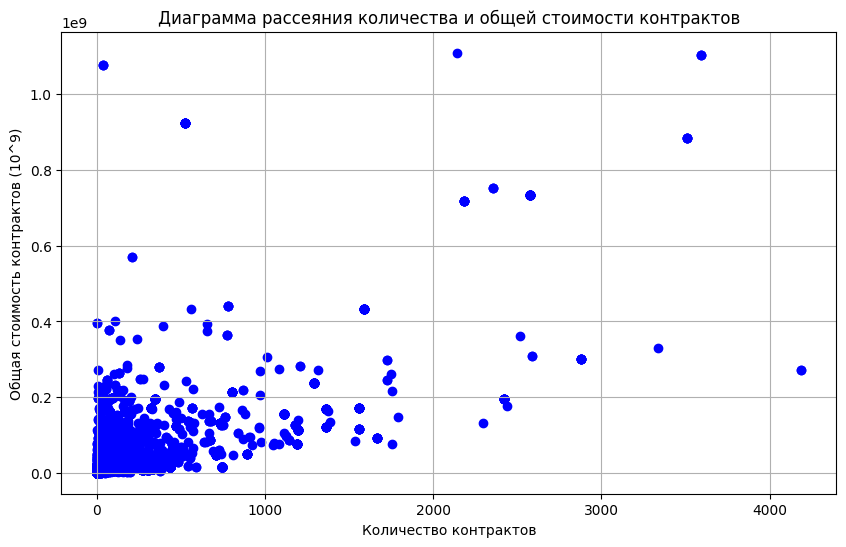

In [153]:
# Создаем диаграмму рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(df['history_signed_contract_before_rnp'], df['history_sum_price_before_rnp'], color='blue')

# Название и метки осей
plt.title('Диаграмма рассеяния количества и общей стоимости контрактов')
plt.xlabel('Количество контрактов')
plt.ylabel('Общая стоимость контрактов (10^9)')

# Показать сетку для удобства восприятия
plt.grid(True)
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по истории закупок.png') 
# Показать график
plt.show()

In [173]:
# Рассчитываем описательную статистику для каждого столбца
descriptive_stats = df[['history_signed_contract_before_rnp', 'history_sum_price_before_rnp']].describe()
print(descriptive_stats)

       history_signed_contract_before_rnp  history_sum_price_before_rnp
count                        13197.000000                  1.319700e+04
mean                           100.822839                  2.674151e+07
std                            286.752249                  7.264489e+07
min                              0.000000                  0.000000e+00
25%                              2.000000                  5.178350e+05
50%                             14.000000                  6.153114e+06
75%                             67.000000                  2.217761e+07
max                           4187.000000                  1.109331e+09


In [195]:
# Отфильтруем данные по заданным условиям
filtered_data = df[(df['history_signed_contract_before_rnp'] < 5) & (df['history_sum_price_before_rnp'] < 150000)]

# Подсчитаем количество удовлетворяющих условиям записей
count_filtered = filtered_data.shape[0]

# Подсчитаем общее количество записей в исходных данных
total_count = df.shape[0]

# Рассчитаем долю удовлетворяющих условиям записей от общего числа записей
fraction = count_filtered / total_count

print(f"Количество записей с 'history_signed_contract_before_rnp' < 5 и 'history_sum_price_before_rnp' < 150000: {count_filtered}")
print(f"Общее количество записей: {total_count}")
print(f"Доля записей, удовлетворяющих условиям: {fraction:.2%}")

Количество записей с 'history_signed_contract_before_rnp' < 5 и 'history_sum_price_before_rnp' < 150000: 2614
Общее количество записей: 13197
Доля записей, удовлетворяющих условиям: 19.81%


## ЮЛ

### То же самое проделаем с ОКВЭД, как с ИП

In [64]:
df_comp = pd.read_csv('rnp_companies_fin_employees_info_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str})

In [67]:
new_column = df_comp['main_okved_code'].str[:2]
# Выбираем позицию, где должен быть вставлен новый столбец (после 5-го столбца, индексация с нуля)
position = 6

# Вставляем столбец
df_comp.insert(loc=position, column='main_okved_code_class', value=new_column)

In [69]:
result = pd.merge(df_comp, check_okved[['Коды ОКВЭД', 'Наименование разделов']], 
                  left_on='main_okved_code_class', right_on='Коды ОКВЭД', how='left').drop(columns='Коды ОКВЭД')

In [71]:
new_column = result['Наименование разделов']
# Выбираем позицию, где должен быть вставлен новый столбец (после 6-го столбца, индексация с нуля)
position = 7
# Вставляем столбец
result.insert(loc=position, column='main_okved_name_class', value=new_column)

In [73]:
result.drop('Наименование разделов', axis=1, inplace=True)

In [74]:
result.to_csv('rnp_companies_fin_employees_info_final_final.csv', index=False)

### Проверим распределения. Анализ данных

In [3]:
df = pd.read_csv('rnp_companies_fin_employees_info_final_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str,
                            'main_okved_code_class': str})

#### Распределение по ИНН

In [200]:
df['supplier_inn'].value_counts()

supplier_inn
2537124300    296
6686123572    226
7325110908    225
6658439380    201
6670118295    190
             ... 
6686108479      1
3663091752      1
5905280219      1
7840508297      1
4025419633      1
Name: count, Length: 23718, dtype: int64

In [206]:
supplier_counts = df['supplier_inn'].value_counts()
supplier_counts[supplier_counts == 5]

supplier_inn
6234191785    5
6658531562    5
2723115409    5
7814747757    5
7706774129    5
             ..
7810831790    5
7725768515    5
6670344375    5
3525385934    5
0562073303    5
Name: count, Length: 350, dtype: int64

<>:25: SyntaxWarning:

invalid escape sequence '\e'

<>:25: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\469204312.py:25: SyntaxWarning:

invalid escape sequence '\e'



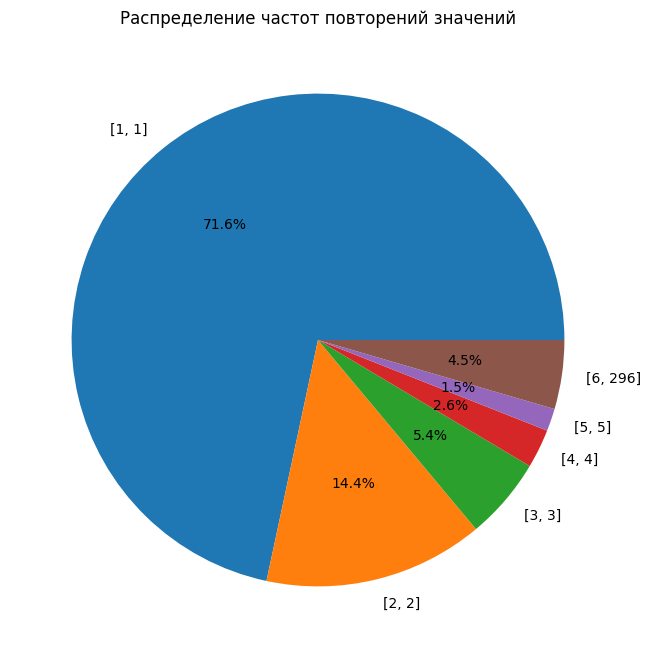

In [207]:
column = df['supplier_inn']

# Получаем количество каждого уникального значения в столбце
value_counts = column.value_counts()

# Получаем распределение частот повторений
frequency_distribution = value_counts.value_counts().sort_index()

# Общее количество элементов
total_counts = frequency_distribution.sum()

# Определяем, какие значения составляют менее 1% от общего числа
small_values = frequency_distribution[frequency_distribution / total_counts < 0.01]

# Объединяем малые значения в одну категорию
other_category_value = small_values.sum()
frequency_distribution = frequency_distribution[frequency_distribution / total_counts >= 0.01]
frequency_distribution['[{}, {}]'.format(small_values.index.min(), small_values.index.max())] = other_category_value

# Создаем круговую диаграмму
plt.figure(figsize=(12, 8))
frequency_distribution.plot(kind='pie', autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '', labels=['[{}, {}]'.format(i, i) if i not in ['[{}, {}]'.format(small_values.index.min(), small_values.index.max())] else i for i in frequency_distribution.index])
plt.title('Распределение частот повторений значений')
plt.ylabel('')  # Удаление метки оси y
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение по ИНН.png') 
plt.show()

#### Распределение по региону

In [208]:
df['region_name'].value_counts()

region_name
Москва                             9977
Свердловская область               3842
Санкт-Петербург                    3765
Московская область                 2253
Ростовская область                 1708
                                   ... 
Еврейская автономная область         32
Калмыкия (Республика)                22
Карачаево-Черкесская Республика      17
Чукотский автономный округ           16
Байконур                              3
Name: count, Length: 83, dtype: int64

<>:11: SyntaxWarning:

invalid escape sequence '\e'

<>:11: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2063796431.py:11: SyntaxWarning:

invalid escape sequence '\e'



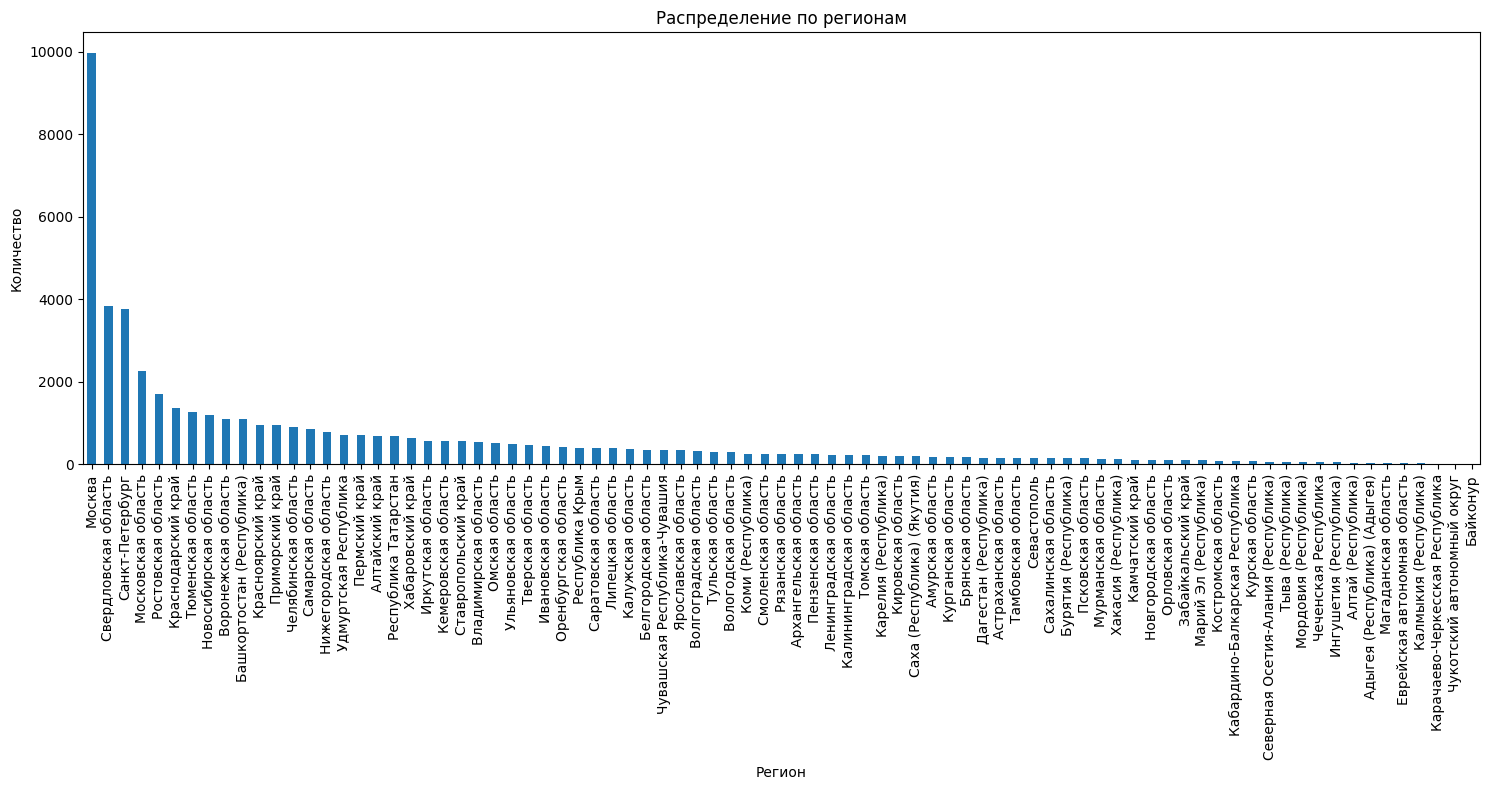

In [210]:
region_counts_sorted = df['region_name'].value_counts().sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(15, 8))
region_counts_sorted.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Распределение по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество')
plt.tight_layout()
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение по регионам.png') 
plt.show()

<>:10: SyntaxWarning:

invalid escape sequence '\e'

<>:10: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2509312287.py:10: SyntaxWarning:

invalid escape sequence '\e'



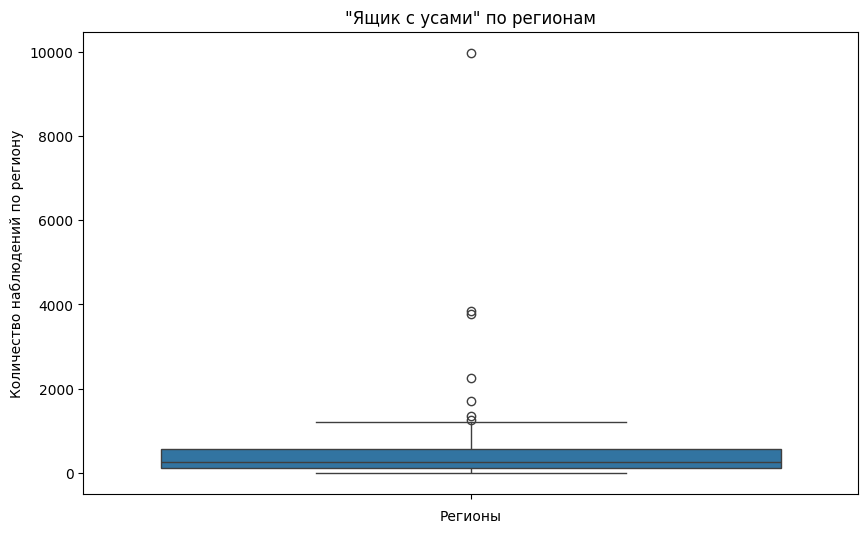

count      83.000000
mean      593.626506
std      1236.836451
min         3.000000
25%       124.000000
50%       252.000000
75%       565.500000
max      9977.000000
Name: count, dtype: float64


In [212]:
# Подсчет количества для каждого региона
region_counts = df['region_name'].value_counts()

# Визуализация общего распределения
plt.figure(figsize=(10, 6))
sns.boxplot(data=region_counts)
plt.title('"Ящик с усами" по регионам')
plt.xlabel('Регионы')
plt.ylabel('Количество наблюдений по региону')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\ящик с усами по регионам.png') 
plt.show()

# Вывод статистического анализа
print(region_counts.describe())

#### Распределение по виду деятельности

In [213]:
df['main_okved_name_class'].value_counts()

main_okved_name_class
Торговля оптовая, кроме оптовой торговли автотранспортными средствами и мотоциклами                                          15813
Строительство зданий                                                                                                          7889
Работы строительные специализированные                                                                                        4591
Деятельность в области архитектуры и инженерно-технического проектирования; технических испытаний, исследований и анализа     2323
Деятельность по обслуживанию зданий и территорий                                                                              1908
                                                                                                                             ...  
Производство металлургическое                                                                                                    6
Предоставление услуг в области добычи полезных ископаемых    

<>:11: SyntaxWarning:

invalid escape sequence '\e'

<>:11: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\3738769305.py:11: SyntaxWarning:

invalid escape sequence '\e'



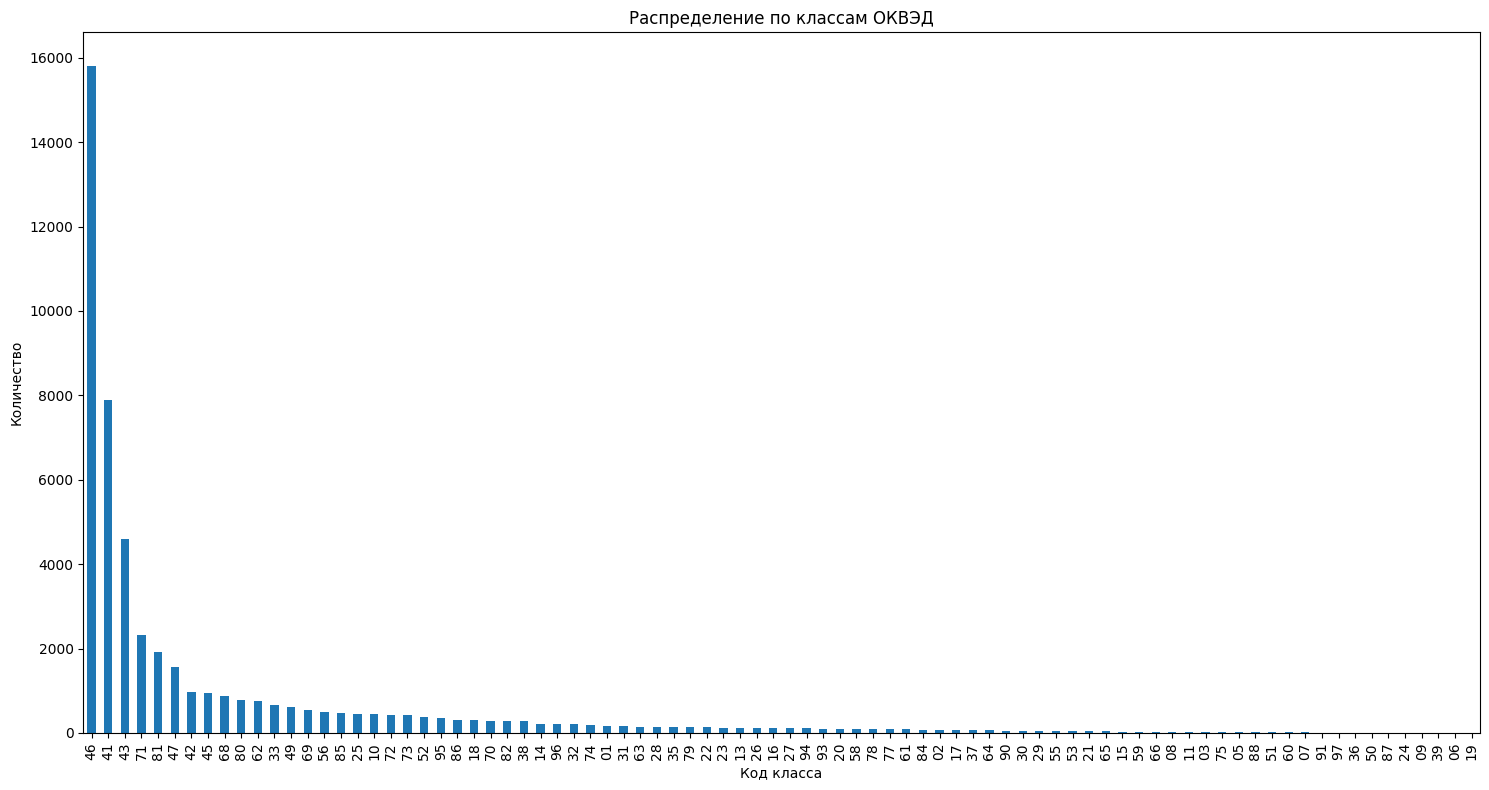

In [216]:
class_counts_sorted = df['main_okved_code_class'].value_counts().sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(15, 8))
class_counts_sorted.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Распределение по классам ОКВЭД')
plt.xlabel('Код класса')
plt.ylabel('Количество')
plt.tight_layout()
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение по классам.png') 
plt.show()

<>:10: SyntaxWarning:

invalid escape sequence '\e'

<>:10: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\3382998417.py:10: SyntaxWarning:

invalid escape sequence '\e'



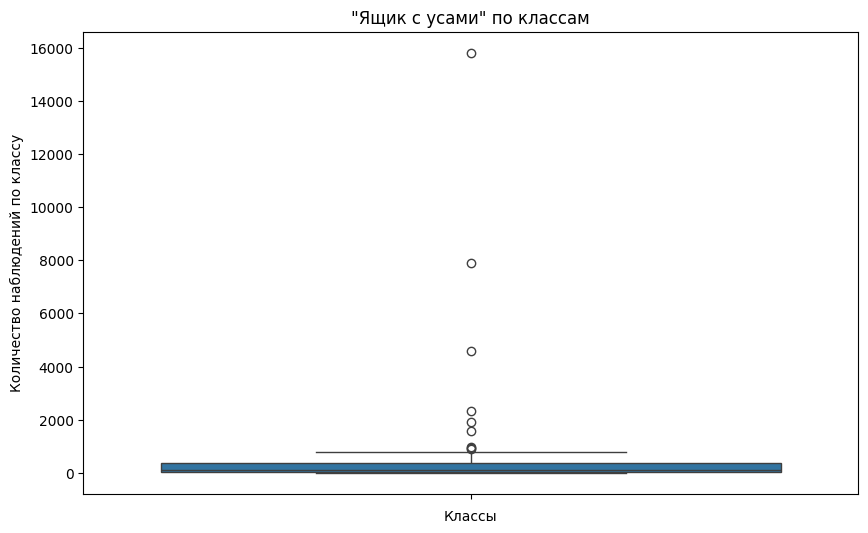

count       84.000000
mean       586.488095
std       1973.628958
min          1.000000
25%         31.750000
50%        111.000000
75%        358.000000
max      15813.000000
Name: count, dtype: float64


In [215]:
# Подсчет количества для каждого класса
class_counts = df['main_okved_code_class'].value_counts()

# Визуализация общего распределения
plt.figure(figsize=(10, 6))
sns.boxplot(data=class_counts)
plt.title('"Ящик с усами" по классам')
plt.xlabel('Классы')
plt.ylabel('Количество наблюдений по классу')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\ящик с усами по классам.png') 
plt.show()

# Вывод статистического анализа
print(class_counts.describe())

#### Распределение по годам добавления в РНП

In [217]:
df['rnp_entry_date_year'].value_counts()

rnp_entry_date_year
2021    9021
2019    8062
2020    7841
2018    5179
2015    4783
2017    4535
2016    4286
2014    2976
2022    2695
Name: count, dtype: int64

<>:11: SyntaxWarning:

invalid escape sequence '\e'

<>:11: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\4006194817.py:11: SyntaxWarning:

invalid escape sequence '\e'



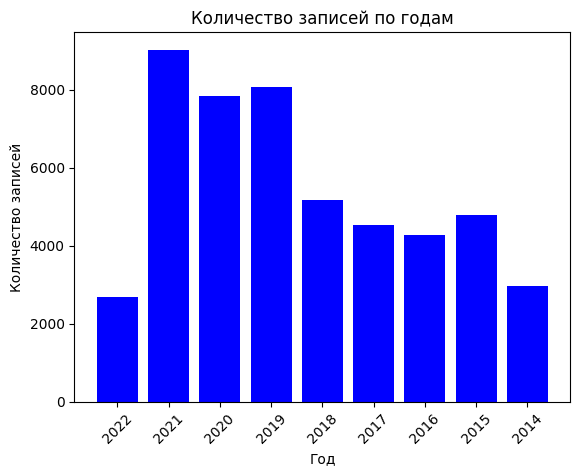

In [218]:
publish_count = df['rnp_entry_date_year'].value_counts().sort_index(ascending=False)

# Создаем гистограмму
plt.bar(publish_count.index.astype(str), publish_count.values, color='blue')

# Настройка визуализации
plt.xlabel('Год')
plt.ylabel('Количество записей')
plt.title('Количество записей по годам')
plt.xticks(rotation=45)  # Поворачиваем метки на оси X для лучшей читаемости
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение по годам.png') 
# Показываем гистограмму
plt.show()

#### Распределение по разнице между годом регистрации и годом вхождения в РНП

In [219]:
df['date_diff_between_reg_entry']

0         4.4
1         1.5
2        12.3
3        12.3
4        12.3
         ... 
49373    12.0
49374     1.0
49375     8.0
49376     8.4
49377     9.3
Name: date_diff_between_reg_entry, Length: 49378, dtype: float64

In [220]:
df['date_diff_between_reg_entry'].describe()

count    49271.000000
mean         5.339670
std          5.175213
min          0.100000
25%          1.700000
50%          3.600000
75%          7.400000
max         32.300000
Name: date_diff_between_reg_entry, dtype: float64

<>:10: SyntaxWarning:

invalid escape sequence '\e'

<>:10: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\2312322931.py:10: SyntaxWarning:

invalid escape sequence '\e'



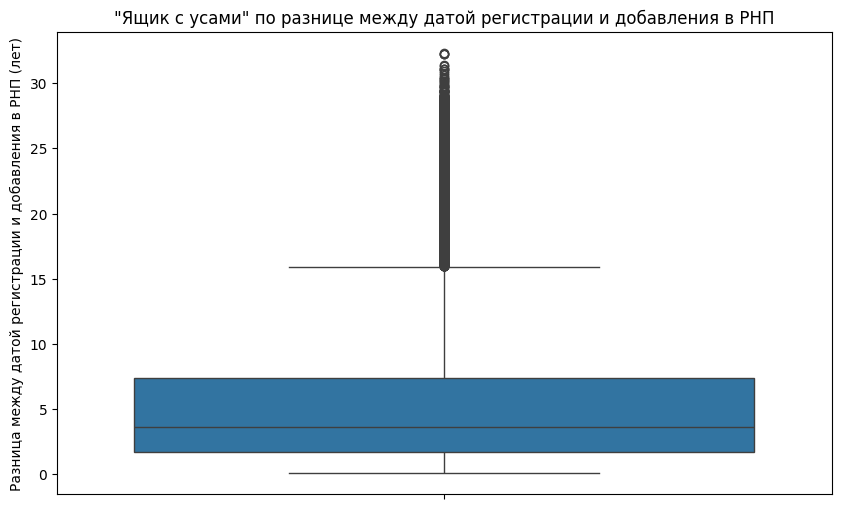

count    49271.000000
mean         5.339670
std          5.175213
min          0.100000
25%          1.700000
50%          3.600000
75%          7.400000
max         32.300000
Name: date_diff_between_reg_entry, dtype: float64


In [225]:
# Подсчет количества для каждого класса
date_counts = df['date_diff_between_reg_entry']

# Визуализация общего распределения
plt.figure(figsize=(10, 6))
sns.boxplot(data=date_counts)
plt.title('"Ящик с усами" по разнице между датой регистрации и добавления в РНП')
plt.xlabel('')
plt.ylabel('Разница между датой регистрации и добавления в РНП (лет)')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\ящик с усами по reg_entry.png') 
plt.show()

# Вывод статистического анализа
print(date_counts.describe())

#### Распределение по причине добавления в РНП

In [226]:
df['rnp_reason'].value_counts()

rnp_reason
CANCEL_CONTRACT     34722
WINNER_DEVIATION    14656
Name: count, dtype: int64

#### Распределение по цене контракта

In [230]:
df['contract_price_amount'].notna().sum()

44091

In [231]:
df['contract_price_amount']

0          93750.00
1         530316.48
2         876043.80
3         292014.60
4         584029.20
            ...    
49373    1073410.35
49374     397913.43
49375     207966.20
49376    1172488.50
49377     416000.00
Name: contract_price_amount, Length: 49378, dtype: float64

In [232]:
44091/49378

0.8929280246263518

<>:13: SyntaxWarning:

invalid escape sequence '\e'

<>:13: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\1099797718.py:13: SyntaxWarning:

invalid escape sequence '\e'



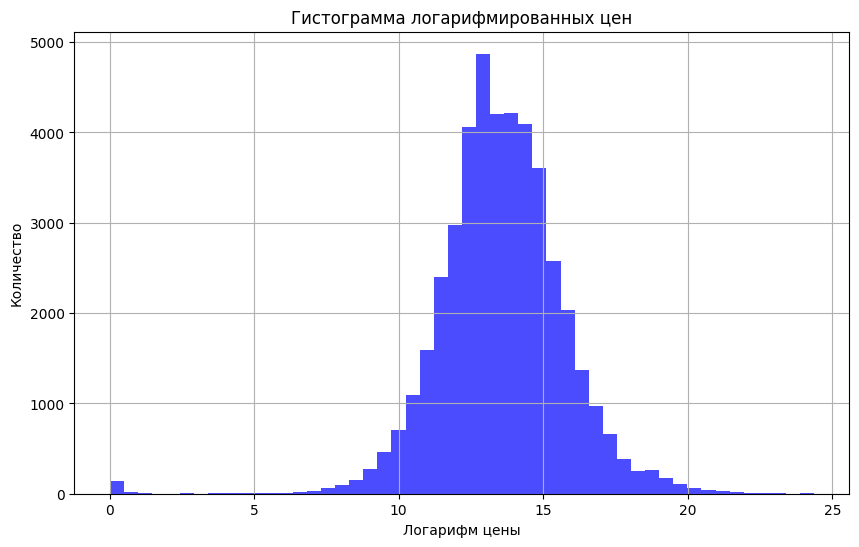

In [233]:
prices = df['contract_price_amount']

# Предположим, что prices - это ваш массив с ценами
prices = np.array(prices)  # Преобразование списка в массив NumPy, если это еще не сделано
log_prices = np.log(prices + 1)  # Логарифмирование цен, +1 чтобы избежать log(0)

plt.figure(figsize=(10, 6))
plt.hist(log_prices, bins=50, color='blue', alpha=0.7)
plt.title('Гистограмма логарифмированных цен')
plt.xlabel('Логарифм цены')
plt.ylabel('Количество')
plt.grid(True)
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение по ценам контракта.png') 
plt.show()

In [228]:
prices = df['contract_price_amount']
print("Минимальная цена:", np.min(prices))
print("Максимальная цена:", np.max(prices))
print("Средняя цена:", np.mean(prices))
print("Медиана цен:", np.median(prices))
print("Стандартное отклонение:", np.std(prices))
print("Квартили:", np.percentile(prices, [25, 50, 75]))

print("Медиана цен (игнорируя NaN):", np.nanmedian(prices))
print("Квартили (игнорируя NaN):", np.nanpercentile(prices, [25, 50, 75]))

Минимальная цена: 0.0
Максимальная цена: 38477099159.82
Средняя цена: 15679174.74304053
Медиана цен: nan
Стандартное отклонение: 352284490.8868328
Квартили: [nan nan nan]
Медиана цен (игнорируя NaN): 746801.94
Квартили (игнорируя NaN): [ 220173.49  746801.94 2770099.  ]


In [234]:
15679174/1800029 

8.71051188619739

In [235]:
38477099159 / 472779698 

81.38483805833812

#### Распределение по истории поставщика

In [236]:
df['history_sum_price_before_rnp'].describe()

count    4.937800e+04
mean     2.854575e+08
std      3.336704e+09
min      0.000000e+00
25%      5.409723e+06
50%      2.412291e+07
75%      9.642218e+07
max      2.356410e+11
Name: history_sum_price_before_rnp, dtype: float64

In [237]:
df['history_signed_contract_before_rnp'].describe()

count    49378.000000
mean       169.280915
std        509.453753
min          0.000000
25%          9.000000
50%         33.000000
75%        117.000000
max      27270.000000
Name: history_signed_contract_before_rnp, dtype: float64

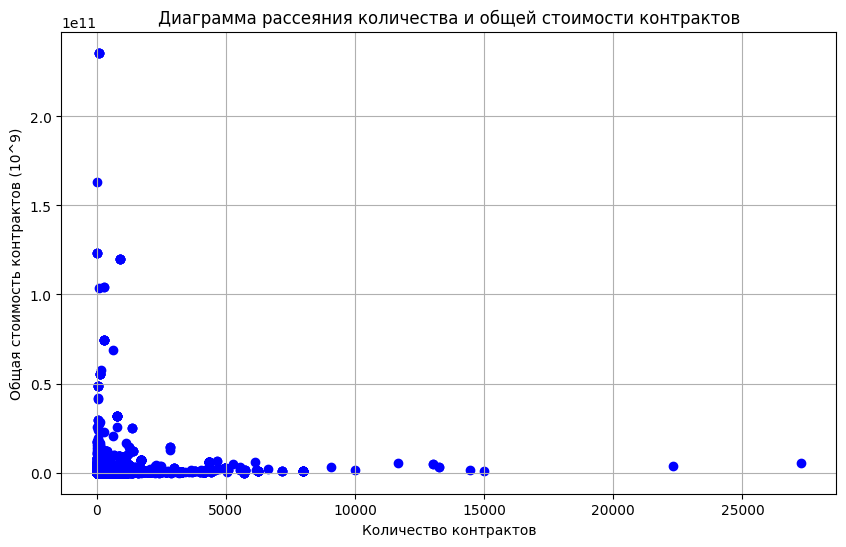

In [238]:
# Создаем диаграмму рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(df['history_signed_contract_before_rnp'], df['history_sum_price_before_rnp'], color='blue')

# Название и метки осей
plt.title('Диаграмма рассеяния количества и общей стоимости контрактов')
plt.xlabel('Количество контрактов')
plt.ylabel('Общая стоимость контрактов (10^9)')

# Показать сетку для удобства восприятия
plt.grid(True)
#plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\распределение по истории закупок.png') 
# Показать график
plt.show()

<>:21: SyntaxWarning:

invalid escape sequence '\e'

<>:21: SyntaxWarning:

invalid escape sequence '\e'

C:\Users\ww\AppData\Local\Temp\ipykernel_14396\3335705539.py:21: SyntaxWarning:

invalid escape sequence '\e'



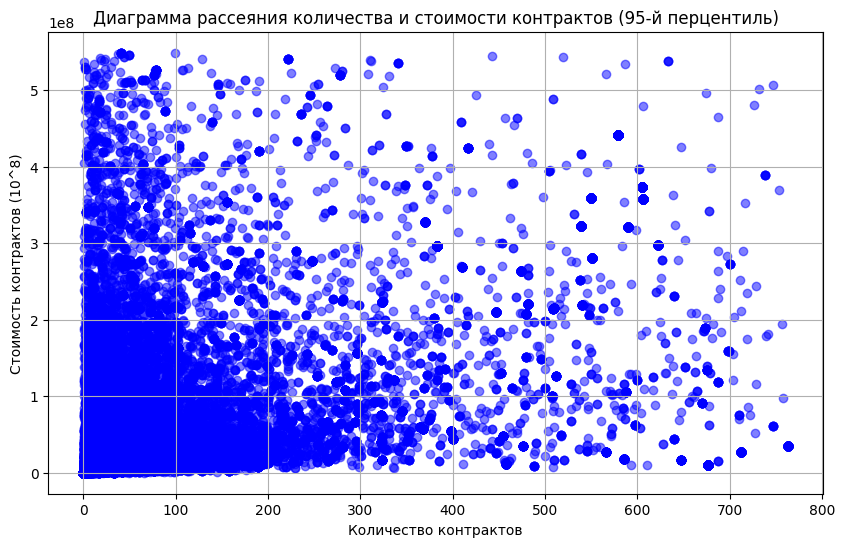

In [261]:
# Определение 95-го процентиля для каждой оси
percentile95_x = np.percentile(df['history_signed_contract_before_rnp'], 95)
percentile95_y = np.percentile(df['history_sum_price_before_rnp'], 95)

# Фильтрация данных для удаления экстремальных выбросов
filtered_df = df[(df['history_signed_contract_before_rnp'] <= percentile95_x) &
                 (df['history_sum_price_before_rnp'] <= percentile95_y)]

# Создаем диаграмму рассеяния с прозрачностью точек
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['history_signed_contract_before_rnp'], filtered_df['history_sum_price_before_rnp'], 
            color='blue', alpha=0.5)  # alpha контролирует прозрачность

# Название и метки осей
plt.title('Диаграмма рассеяния количества и стоимости контрактов (95-й перцентиль)')
plt.xlabel('Количество контрактов')
plt.ylabel('Стоимость контрактов (10^8)')

# Показать сетку для удобства восприятия
plt.grid(True)
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение по истории закупок.png') 
# Показать график
plt.show()

In [262]:
# Рассчитываем описательную статистику для каждого столбца
descriptive_stats = df[['history_signed_contract_before_rnp', 'history_sum_price_before_rnp']].describe()
print(descriptive_stats)

       history_signed_contract_before_rnp  history_sum_price_before_rnp
count                        49378.000000                  4.937800e+04
mean                           169.280915                  2.854575e+08
std                            509.453753                  3.336704e+09
min                              0.000000                  0.000000e+00
25%                              9.000000                  5.409723e+06
50%                             33.000000                  2.412291e+07
75%                            117.000000                  9.642218e+07
max                          27270.000000                  2.356410e+11


In [264]:
# Отфильтруем данные по заданным условиям
filtered_data = df[(df['history_signed_contract_before_rnp'] < 300) & (df['history_sum_price_before_rnp'] < 500000000)]

# Подсчитаем количество удовлетворяющих условиям записей
count_filtered = filtered_data.shape[0]

# Подсчитаем общее количество записей в исходных данных
total_count = df.shape[0]

# Рассчитаем долю удовлетворяющих условиям записей от общего числа записей
fraction = count_filtered / total_count

print(f"Количество записей с 'history_signed_contract_before_rnp' < 300 и 'history_sum_price_before_rnp' < 500000000: {count_filtered}")
print(f"Общее количество записей: {total_count}")
print(f"Доля записей, удовлетворяющих условиям: {fraction:.2%}")

Количество записей с 'history_signed_contract_before_rnp' < 300 и 'history_sum_price_before_rnp' < 500000000: 40726
Общее количество записей: 49378
Доля записей, удовлетворяющих условиям: 82.48%


#### Распределение по количеству сотрудников

In [6]:
df['employees'].describe()

count    33772.000000
mean         7.373801
std         34.631955
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2334.000000
Name: employees, dtype: float64

In [109]:
# Отфильтруем данные по заданным условиям
filtered_data = df[(df['employees'] >= 0) & (df['employees'] < 5)]

# Подсчитаем количество удовлетворяющих условиям записей
count_filtered = filtered_data.shape[0]

# Подсчитаем общее количество записей в исходных данных
total_count = df['employees'].notna().sum()

# Рассчитаем долю удовлетворяющих условиям записей от общего числа записей
fraction = count_filtered / total_count

print(f"Количество записей: {count_filtered}")
print(f"Общее количество записей: {total_count}")
print(f"Доля записей, удовлетворяющих условиям: {fraction:.2%}")

Количество записей: 25085
Общее количество записей: 33772
Доля записей, удовлетворяющих условиям: 74.28%


<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ww\AppData\Local\Temp\ipykernel_10704\3295729355.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение кол-ва сотрудников.png')


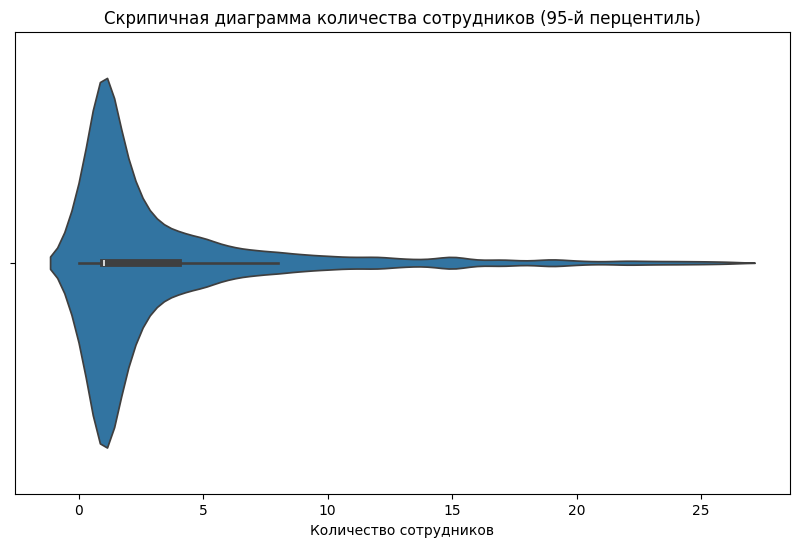

In [107]:
df_test = df.dropna(subset=['employees'])

# Вычисляем 95-й перцентиль
percentile_95 = np.percentile(df_test['employees'], 95)

# Фильтруем данные, чтобы использовать только значения до 95-го перцентиля
filtered_df = df_test[df_test['employees'] <= percentile_95]

# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='employees')
plt.title('Скрипичная диаграмма количества сотрудников (95-й перцентиль)')
plt.xlabel('Количество сотрудников')
plt.savefig('D:\Рабочий стол\educ\Госзакупки\histograms_graphs_charts\ЮЛ\распределение кол-ва сотрудников.png') 
plt.show()

#### Распределение по денежные средства и денежные эквиваленты

Анализ переменной: Денежные средства и денежные эквиваленты
Описательная статистика:
count    3.801800e+04
mean     6.125816e+06
std      1.682302e+08
min     -1.297500e+07
25%      1.700000e+04
50%      2.220000e+05
75%      1.296750e+06
max      2.813250e+10
Name: Денежные средства и денежные эквиваленты, dtype: float64


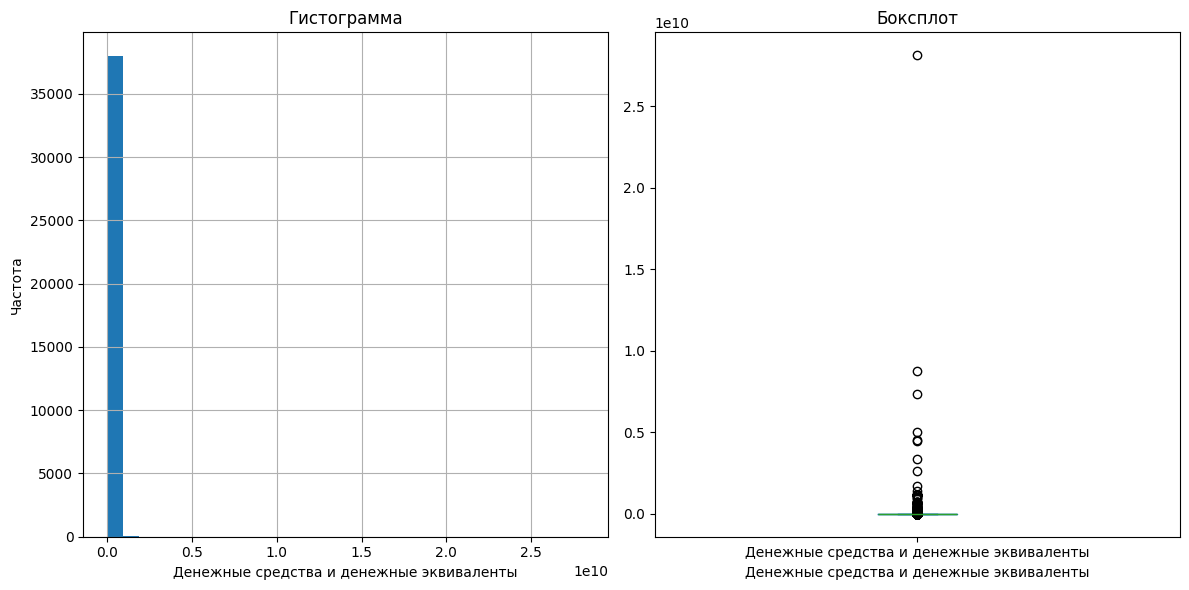

Анализ переменной: Кредиторская задолженность
Описательная статистика:
count    3.759600e+04
mean     8.354940e+07
std      1.204967e+09
min     -1.060000e+06
25%      5.260000e+05
50%      3.806000e+06
75%      1.954800e+07
max      1.325062e+11
Name: Кредиторская задолженность, dtype: float64


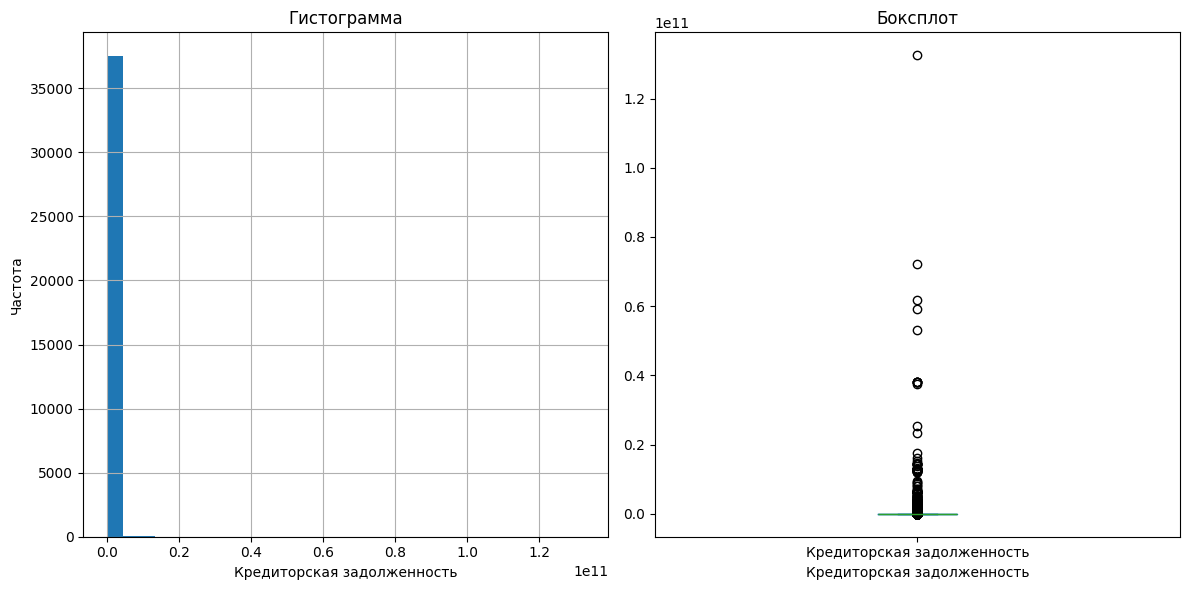

Анализ переменной: Выручка
Описательная статистика:
count    3.797500e+04
mean     1.198784e+08
std      1.621030e+09
min     -4.499000e+06
25%      3.393500e+06
50%      1.282400e+07
75%      4.536600e+07
max      2.173980e+11
Name: Выручка, dtype: float64


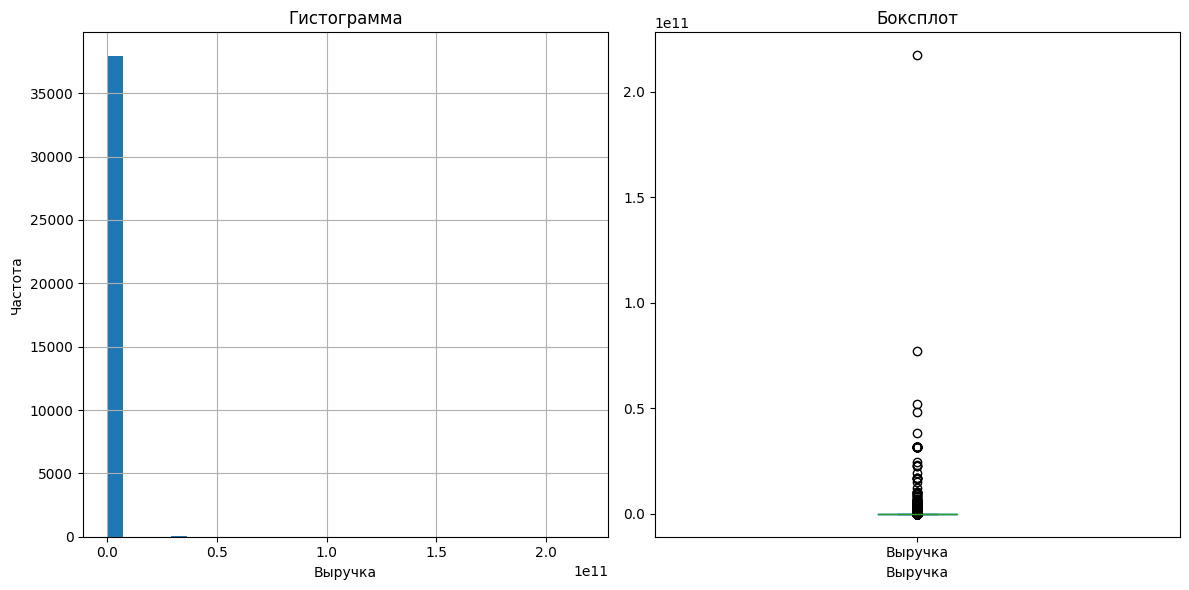

Анализ переменной: Чистая прибыль (убыток)
Описательная статистика:
count    3.832500e+04
mean    -8.043096e+06
std      2.548133e+08
min     -3.319791e+10
25%      0.000000e+00
50%      1.660000e+05
75%      1.074000e+06
max      5.257868e+09
Name: Чистая прибыль (убыток), dtype: float64


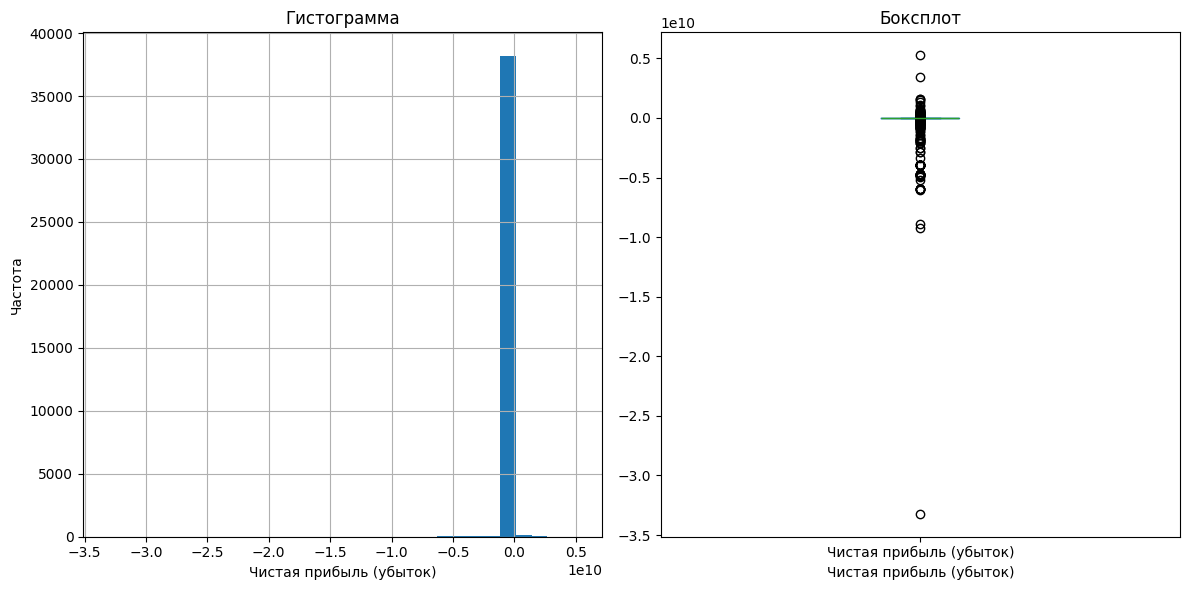

In [118]:
# Список переменных для анализа
variables = [
    'Денежные средства и денежные эквиваленты',
    'Кредиторская задолженность',
    'Выручка',
    'Чистая прибыль (убыток)'
]

# Функция для вывода описательной статистики и визуализации
def analyze_variable(data, variable):
    print(f"Анализ переменной: {variable}")
    print("Описательная статистика:")
    print(data[variable].describe())
    
    # Визуализация гистограммы
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    data[variable].hist(bins=30)
    plt.title('Гистограмма')
    plt.xlabel(variable)
    plt.ylabel('Частота')

    # Визуализация боксплота
    plt.subplot(1, 2, 2)
    data[variable].plot(kind='box')
    plt.title('Боксплот')
    plt.xlabel(variable)
    
    plt.tight_layout()
    plt.show()

# Анализ каждой переменной
for var in variables:
    analyze_variable(df, var)

In [126]:
# Список переменных для анализа
variables = [
    'Денежные средства и денежные эквиваленты',
    'Кредиторская задолженность',
    'Выручка',
    'Чистая прибыль (убыток)'
]

# Функция для вывода описательной статистики и визуализации
def analyze_variable(data, variable):
    print(f"Анализ переменной: {variable}")
    print("Описательная статистика:")
    print(data[variable].describe())
    
    # Обработка выбросов с помощью процентилей
    lower_bound = data[variable].quantile(0.05)
    upper_bound = data[variable].quantile(0.95)
    filtered_data = data[(data[variable] >= lower_bound) & (data[variable] <= upper_bound)]
    
    # Визуализация гистограммы
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    filtered_data[variable].hist(bins=30)
    plt.title('Гистограмма (95-й перцентиль)')
    plt.xlabel(variable)
    plt.ylabel('Частота')

    # Визуализация боксплота
    plt.subplot(1, 2, 2)
    filtered_data[variable].plot(kind='box')
    plt.title('Боксплот (95-й перцентиль)')
    plt.xlabel(variable)
    
    plt.tight_layout()
    #plt.show()
    # Сохранение графиков с уникальным именем для каждой переменной
    filename = f"D:\\Рабочий стол\\educ\\Госзакупки\\histograms_graphs_charts\\ЮЛ\\распределение по {variable}.png"
    plt.savefig(filename)
    plt.close()  # Закрытие фигуры после сохранения

# Анализ каждой переменной
for var in variables:
    analyze_variable(df, var)

Анализ переменной: Денежные средства и денежные эквиваленты
Описательная статистика:
count    3.801800e+04
mean     6.125816e+06
std      1.682302e+08
min     -1.297500e+07
25%      1.700000e+04
50%      2.220000e+05
75%      1.296750e+06
max      2.813250e+10
Name: Денежные средства и денежные эквиваленты, dtype: float64
Анализ переменной: Кредиторская задолженность
Описательная статистика:
count    3.759600e+04
mean     8.354940e+07
std      1.204967e+09
min     -1.060000e+06
25%      5.260000e+05
50%      3.806000e+06
75%      1.954800e+07
max      1.325062e+11
Name: Кредиторская задолженность, dtype: float64
Анализ переменной: Выручка
Описательная статистика:
count    3.797500e+04
mean     1.198784e+08
std      1.621030e+09
min     -4.499000e+06
25%      3.393500e+06
50%      1.282400e+07
75%      4.536600e+07
max      2.173980e+11
Name: Выручка, dtype: float64
Анализ переменной: Чистая прибыль (убыток)
Описательная статистика:
count    3.832500e+04
mean    -8.043096e+06
std      2